In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_roi_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 1040)
(657450, 8)
validation
(74368, 1040)
(74368, 8)
test
(91684, 1040)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1040)]            0         


 dense (Dense)               (None, 1024)              1065984   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1756040 (6.70 MB)


Trainable params: 1756040 (6.70 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 1:47 - loss: 2.3648 - STD: 0.0485 - MAE: 0.2248

 3/66 [>.............................] - ETA: 1s - loss: 1.8807 - STD: 0.0663 - MAE: 0.2039  

 5/66 [=>............................] - ETA: 1s - loss: 1.6723 - STD: 0.1184 - MAE: 0.1801

 7/66 [==>...........................] - ETA: 1s - loss: 1.5868 - STD: 0.1554 - MAE: 0.1640

 9/66 [===>..........................] - ETA: 1s - loss: 1.5439 - STD: 0.1771 - MAE: 0.1548

11/66 [====>.........................] - ETA: 1s - loss: 1.5072 - STD: 0.1880 - MAE: 0.1498

13/66 [====>.........................] - ETA: 1s - loss: 1.4813 - STD: 0.1913 - MAE: 0.1482

15/66 [=====>........................] - ETA: 1s - loss: 1.4638 - STD: 0.1903 - MAE: 0.1483

17/66 [======>.......................] - ETA: 1s - loss: 1.4506 - STD: 0.1882 - MAE: 0.1490

19/66 [=======>......................] - ETA: 1s - loss: 1.4381 - STD: 0.1866 - MAE: 0.1494

21/66 [========>.....................] - ETA: 1s - loss: 1.4245 - STD: 0.1863 - MAE: 0.1492

23/66 [=========>....................] - ETA: 1s - loss: 1.4150 - STD: 0.1872 - MAE: 0.1486

25/66 [==========>...................] - ETA: 1s - loss: 1.4076 - STD: 0.1888 - MAE: 0.1479

27/66 [===========>..................] - ETA: 1s - loss: 1.4013 - STD: 0.1905 - MAE: 0.1471

29/66 [============>.................] - ETA: 0s - loss: 1.3955 - STD: 0.1918 - MAE: 0.1466

30/66 [============>.................] - ETA: 2s - loss: 1.3931 - STD: 0.1922 - MAE: 0.1463

32/66 [=============>................] - ETA: 1s - loss: 1.3878 - STD: 0.1925 - MAE: 0.1461

34/66 [==============>...............] - ETA: 1s - loss: 1.3824 - STD: 0.1924 - MAE: 0.1460

36/66 [===============>..............] - ETA: 1s - loss: 1.3783 - STD: 0.1919 - MAE: 0.1461

38/66 [================>.............] - ETA: 1s - loss: 1.3750 - STD: 0.1913 - MAE: 0.1463

40/66 [=================>............] - ETA: 1s - loss: 1.3712 - STD: 0.1909 - MAE: 0.1464

42/66 [==================>...........] - ETA: 1s - loss: 1.3683 - STD: 0.1907 - MAE: 0.1464

44/66 [===================>..........] - ETA: 1s - loss: 1.3658 - STD: 0.1907 - MAE: 0.1464

46/66 [===================>..........] - ETA: 0s - loss: 1.3635 - STD: 0.1909 - MAE: 0.1463

48/66 [====================>.........] - ETA: 0s - loss: 1.3615 - STD: 0.1912 - MAE: 0.1462

50/66 [=====================>........] - ETA: 0s - loss: 1.3595 - STD: 0.1913 - MAE: 0.1461

52/66 [======================>.......] - ETA: 0s - loss: 1.3575 - STD: 0.1914 - MAE: 0.1460

54/66 [=======================>......] - ETA: 0s - loss: 1.3557 - STD: 0.1913 - MAE: 0.1460

56/66 [========================>.....] - ETA: 0s - loss: 1.3542 - STD: 0.1912 - MAE: 0.1461

58/66 [=========================>....] - ETA: 0s - loss: 1.3527 - STD: 0.1911 - MAE: 0.1461

60/66 [==========================>...] - ETA: 0s - loss: 1.3515 - STD: 0.1911 - MAE: 0.1461

62/66 [===========================>..] - ETA: 0s - loss: 1.3495 - STD: 0.1911 - MAE: 0.1460

64/66 [============================>.] - ETA: 0s - loss: 1.3479 - STD: 0.1912 - MAE: 0.1459

66/66 [==============================] - ETA: 0s - loss: 1.3468 - STD: 0.1914 - MAE: 0.1459

66/66 [==============================] - 5s 54ms/step - loss: 1.3468 - STD: 0.1914 - MAE: 0.1459 - val_loss: 1.2430 - val_STD: 0.1962 - val_MAE: 0.1401


Epoch 2/10000


 1/66 [..............................] - ETA: 3s - loss: 1.3326 - STD: 0.1961 - MAE: 0.1446

 3/66 [>.............................] - ETA: 1s - loss: 1.3226 - STD: 0.1952 - MAE: 0.1446

 5/66 [=>............................] - ETA: 1s - loss: 1.3180 - STD: 0.1938 - MAE: 0.1447

 7/66 [==>...........................] - ETA: 1s - loss: 1.3160 - STD: 0.1928 - MAE: 0.1450

 9/66 [===>..........................] - ETA: 1s - loss: 1.3118 - STD: 0.1921 - MAE: 0.1451

11/66 [====>.........................] - ETA: 1s - loss: 1.3149 - STD: 0.1918 - MAE: 0.1454

13/66 [====>.........................] - ETA: 1s - loss: 1.3148 - STD: 0.1917 - MAE: 0.1455

15/66 [=====>........................] - ETA: 1s - loss: 1.3137 - STD: 0.1916 - MAE: 0.1455

17/66 [======>.......................] - ETA: 1s - loss: 1.3128 - STD: 0.1915 - MAE: 0.1454

19/66 [=======>......................] - ETA: 1s - loss: 1.3128 - STD: 0.1915 - MAE: 0.1455

21/66 [========>.....................] - ETA: 1s - loss: 1.3126 - STD: 0.1915 - MAE: 0.1455

23/66 [=========>....................] - ETA: 1s - loss: 1.3115 - STD: 0.1914 - MAE: 0.1455

25/66 [==========>...................] - ETA: 1s - loss: 1.3110 - STD: 0.1914 - MAE: 0.1454

27/66 [===========>..................] - ETA: 1s - loss: 1.3106 - STD: 0.1915 - MAE: 0.1454

30/66 [============>.................] - ETA: 0s - loss: 1.3103 - STD: 0.1917 - MAE: 0.1453

32/66 [=============>................] - ETA: 0s - loss: 1.3095 - STD: 0.1919 - MAE: 0.1451

34/66 [==============>...............] - ETA: 0s - loss: 1.3094 - STD: 0.1920 - MAE: 0.1451

36/66 [===============>..............] - ETA: 0s - loss: 1.3093 - STD: 0.1921 - MAE: 0.1450

38/66 [================>.............] - ETA: 0s - loss: 1.3092 - STD: 0.1921 - MAE: 0.1450

40/66 [=================>............] - ETA: 0s - loss: 1.3084 - STD: 0.1920 - MAE: 0.1450

42/66 [==================>...........] - ETA: 0s - loss: 1.3076 - STD: 0.1919 - MAE: 0.1450

44/66 [===================>..........] - ETA: 0s - loss: 1.3076 - STD: 0.1919 - MAE: 0.1450

46/66 [===================>..........] - ETA: 0s - loss: 1.3076 - STD: 0.1920 - MAE: 0.1450

48/66 [====================>.........] - ETA: 0s - loss: 1.3080 - STD: 0.1920 - MAE: 0.1450

50/66 [=====================>........] - ETA: 0s - loss: 1.3075 - STD: 0.1920 - MAE: 0.1450

52/66 [======================>.......] - ETA: 0s - loss: 1.3080 - STD: 0.1920 - MAE: 0.1450

54/66 [=======================>......] - ETA: 0s - loss: 1.3073 - STD: 0.1919 - MAE: 0.1450

56/66 [========================>.....] - ETA: 0s - loss: 1.3063 - STD: 0.1919 - MAE: 0.1449

58/66 [=========================>....] - ETA: 0s - loss: 1.3063 - STD: 0.1920 - MAE: 0.1449

60/66 [==========================>...] - ETA: 0s - loss: 1.3065 - STD: 0.1921 - MAE: 0.1449

62/66 [===========================>..] - ETA: 0s - loss: 1.3064 - STD: 0.1920 - MAE: 0.1449

64/66 [============================>.] - ETA: 0s - loss: 1.3060 - STD: 0.1920 - MAE: 0.1449

66/66 [==============================] - ETA: 0s - loss: 1.3058 - STD: 0.1919 - MAE: 0.1449

66/66 [==============================] - 2s 30ms/step - loss: 1.3058 - STD: 0.1919 - MAE: 0.1449 - val_loss: 1.2312 - val_STD: 0.1921 - val_MAE: 0.1410


Epoch 3/10000


 1/66 [..............................] - ETA: 4s - loss: 1.2895 - STD: 0.1918 - MAE: 0.1438

 3/66 [>.............................] - ETA: 1s - loss: 1.2892 - STD: 0.1929 - MAE: 0.1435

 5/66 [=>............................] - ETA: 1s - loss: 1.2873 - STD: 0.1931 - MAE: 0.1434

 7/66 [==>...........................] - ETA: 1s - loss: 1.2897 - STD: 0.1929 - MAE: 0.1436

 9/66 [===>..........................] - ETA: 1s - loss: 1.2915 - STD: 0.1925 - MAE: 0.1438

11/66 [====>.........................] - ETA: 1s - loss: 1.2926 - STD: 0.1923 - MAE: 0.1440

13/66 [====>.........................] - ETA: 1s - loss: 1.2925 - STD: 0.1922 - MAE: 0.1440

15/66 [=====>........................] - ETA: 1s - loss: 1.2932 - STD: 0.1919 - MAE: 0.1441

17/66 [======>.......................] - ETA: 1s - loss: 1.2922 - STD: 0.1914 - MAE: 0.1443

19/66 [=======>......................] - ETA: 1s - loss: 1.2920 - STD: 0.1912 - MAE: 0.1443

21/66 [========>.....................] - ETA: 1s - loss: 1.2897 - STD: 0.1915 - MAE: 0.1440

23/66 [=========>....................] - ETA: 1s - loss: 1.2875 - STD: 0.1919 - MAE: 0.1438

25/66 [==========>...................] - ETA: 1s - loss: 1.2855 - STD: 0.1921 - MAE: 0.1436

27/66 [===========>..................] - ETA: 1s - loss: 1.2836 - STD: 0.1923 - MAE: 0.1434

29/66 [============>.................] - ETA: 0s - loss: 1.2817 - STD: 0.1926 - MAE: 0.1432

31/66 [=============>................] - ETA: 0s - loss: 1.2808 - STD: 0.1927 - MAE: 0.1431

33/66 [==============>...............] - ETA: 0s - loss: 1.2802 - STD: 0.1927 - MAE: 0.1431

35/66 [==============>...............] - ETA: 0s - loss: 1.2786 - STD: 0.1928 - MAE: 0.1429

37/66 [===============>..............] - ETA: 0s - loss: 1.2770 - STD: 0.1930 - MAE: 0.1428

39/66 [================>.............] - ETA: 0s - loss: 1.2755 - STD: 0.1932 - MAE: 0.1426

41/66 [=================>............] - ETA: 0s - loss: 1.2742 - STD: 0.1934 - MAE: 0.1425

43/66 [==================>...........] - ETA: 0s - loss: 1.2723 - STD: 0.1937 - MAE: 0.1423

45/66 [===================>..........] - ETA: 0s - loss: 1.2717 - STD: 0.1939 - MAE: 0.1422

47/66 [====================>.........] - ETA: 0s - loss: 1.2710 - STD: 0.1940 - MAE: 0.1421

49/66 [=====================>........] - ETA: 0s - loss: 1.2696 - STD: 0.1943 - MAE: 0.1419

51/66 [======================>.......] - ETA: 0s - loss: 1.2683 - STD: 0.1943 - MAE: 0.1419

54/66 [=======================>......] - ETA: 0s - loss: 1.2663 - STD: 0.1945 - MAE: 0.1417

56/66 [========================>.....] - ETA: 0s - loss: 1.2647 - STD: 0.1949 - MAE: 0.1415

58/66 [=========================>....] - ETA: 0s - loss: 1.2637 - STD: 0.1948 - MAE: 0.1415

60/66 [==========================>...] - ETA: 0s - loss: 1.2624 - STD: 0.1951 - MAE: 0.1413

62/66 [===========================>..] - ETA: 0s - loss: 1.2612 - STD: 0.1950 - MAE: 0.1414

64/66 [============================>.] - ETA: 0s - loss: 1.2593 - STD: 0.1953 - MAE: 0.1412

66/66 [==============================] - ETA: 0s - loss: 1.2574 - STD: 0.1955 - MAE: 0.1410

66/66 [==============================] - 2s 30ms/step - loss: 1.2574 - STD: 0.1955 - MAE: 0.1410 - val_loss: 1.1371 - val_STD: 0.2044 - val_MAE: 0.1323


Epoch 4/10000


 1/66 [..............................] - ETA: 3s - loss: 1.2029 - STD: 0.1987 - MAE: 0.1382

 3/66 [>.............................] - ETA: 1s - loss: 1.2004 - STD: 0.2036 - MAE: 0.1359

 5/66 [=>............................] - ETA: 1s - loss: 1.1977 - STD: 0.1992 - MAE: 0.1376

 7/66 [==>...........................] - ETA: 1s - loss: 1.1945 - STD: 0.2014 - MAE: 0.1367

 9/66 [===>..........................] - ETA: 1s - loss: 1.1941 - STD: 0.1995 - MAE: 0.1374

11/66 [====>.........................] - ETA: 1s - loss: 1.1905 - STD: 0.2008 - MAE: 0.1367

13/66 [====>.........................] - ETA: 1s - loss: 1.1895 - STD: 0.2007 - MAE: 0.1368

15/66 [=====>........................] - ETA: 1s - loss: 1.1871 - STD: 0.2010 - MAE: 0.1366

17/66 [======>.......................] - ETA: 1s - loss: 1.1851 - STD: 0.2014 - MAE: 0.1364

19/66 [=======>......................] - ETA: 1s - loss: 1.1832 - STD: 0.2012 - MAE: 0.1364

21/66 [========>.....................] - ETA: 1s - loss: 1.1821 - STD: 0.2016 - MAE: 0.1363

23/66 [=========>....................] - ETA: 1s - loss: 1.1805 - STD: 0.2016 - MAE: 0.1362

25/66 [==========>...................] - ETA: 1s - loss: 1.1793 - STD: 0.2015 - MAE: 0.1362

27/66 [===========>..................] - ETA: 1s - loss: 1.1787 - STD: 0.2018 - MAE: 0.1361

29/66 [============>.................] - ETA: 0s - loss: 1.1773 - STD: 0.2015 - MAE: 0.1362

31/66 [=============>................] - ETA: 0s - loss: 1.1746 - STD: 0.2019 - MAE: 0.1360

33/66 [==============>...............] - ETA: 0s - loss: 1.1725 - STD: 0.2017 - MAE: 0.1360

35/66 [==============>...............] - ETA: 0s - loss: 1.1716 - STD: 0.2021 - MAE: 0.1358

37/66 [===============>..............] - ETA: 0s - loss: 1.1703 - STD: 0.2019 - MAE: 0.1359

39/66 [================>.............] - ETA: 0s - loss: 1.1690 - STD: 0.2023 - MAE: 0.1357

41/66 [=================>............] - ETA: 0s - loss: 1.1681 - STD: 0.2019 - MAE: 0.1359

43/66 [==================>...........] - ETA: 0s - loss: 1.1669 - STD: 0.2022 - MAE: 0.1357

45/66 [===================>..........] - ETA: 0s - loss: 1.1655 - STD: 0.2020 - MAE: 0.1358

47/66 [====================>.........] - ETA: 0s - loss: 1.1640 - STD: 0.2023 - MAE: 0.1356

49/66 [=====================>........] - ETA: 0s - loss: 1.1626 - STD: 0.2022 - MAE: 0.1356

51/66 [======================>.......] - ETA: 0s - loss: 1.1607 - STD: 0.2024 - MAE: 0.1355

53/66 [=======================>......] - ETA: 0s - loss: 1.1596 - STD: 0.2023 - MAE: 0.1355

55/66 [========================>.....] - ETA: 0s - loss: 1.1583 - STD: 0.2026 - MAE: 0.1354

57/66 [========================>.....] - ETA: 0s - loss: 1.1569 - STD: 0.2025 - MAE: 0.1354

59/66 [=========================>....] - ETA: 0s - loss: 1.1552 - STD: 0.2026 - MAE: 0.1353

61/66 [==========================>...] - ETA: 0s - loss: 1.1538 - STD: 0.2026 - MAE: 0.1353

63/66 [===========================>..] - ETA: 0s - loss: 1.1523 - STD: 0.2027 - MAE: 0.1352

65/66 [============================>.] - ETA: 0s - loss: 1.1507 - STD: 0.2027 - MAE: 0.1352

66/66 [==============================] - 2s 30ms/step - loss: 1.1503 - STD: 0.2027 - MAE: 0.1352 - val_loss: 1.0454 - val_STD: 0.2100 - val_MAE: 0.1274


Epoch 5/10000


 1/66 [..............................] - ETA: 3s - loss: 1.1080 - STD: 0.2053 - MAE: 0.1337

 3/66 [>.............................] - ETA: 1s - loss: 1.1082 - STD: 0.2038 - MAE: 0.1340

 5/66 [=>............................] - ETA: 1s - loss: 1.1054 - STD: 0.2043 - MAE: 0.1336

 7/66 [==>...........................] - ETA: 1s - loss: 1.1014 - STD: 0.2038 - MAE: 0.1337

 9/66 [===>..........................] - ETA: 1s - loss: 1.0960 - STD: 0.2043 - MAE: 0.1332

11/66 [====>.........................] - ETA: 1s - loss: 1.0948 - STD: 0.2041 - MAE: 0.1333

13/66 [====>.........................] - ETA: 1s - loss: 1.0913 - STD: 0.2044 - MAE: 0.1330

15/66 [=====>........................] - ETA: 1s - loss: 1.0892 - STD: 0.2044 - MAE: 0.1329

17/66 [======>.......................] - ETA: 1s - loss: 1.0850 - STD: 0.2050 - MAE: 0.1324

19/66 [=======>......................] - ETA: 1s - loss: 1.0827 - STD: 0.2050 - MAE: 0.1323

21/66 [========>.....................] - ETA: 1s - loss: 1.0810 - STD: 0.2051 - MAE: 0.1322

23/66 [=========>....................] - ETA: 1s - loss: 1.0767 - STD: 0.2055 - MAE: 0.1318

26/66 [==========>...................] - ETA: 1s - loss: 1.0730 - STD: 0.2058 - MAE: 0.1315

28/66 [===========>..................] - ETA: 1s - loss: 1.0703 - STD: 0.2059 - MAE: 0.1313

30/66 [============>.................] - ETA: 0s - loss: 1.0673 - STD: 0.2062 - MAE: 0.1310

32/66 [=============>................] - ETA: 0s - loss: 1.0648 - STD: 0.2065 - MAE: 0.1308

34/66 [==============>...............] - ETA: 0s - loss: 1.0620 - STD: 0.2071 - MAE: 0.1304

36/66 [===============>..............] - ETA: 0s - loss: 1.0590 - STD: 0.2073 - MAE: 0.1302

38/66 [================>.............] - ETA: 0s - loss: 1.0566 - STD: 0.2074 - MAE: 0.1300

40/66 [=================>............] - ETA: 0s - loss: 1.0543 - STD: 0.2082 - MAE: 0.1295

42/66 [==================>...........] - ETA: 0s - loss: 1.0518 - STD: 0.2081 - MAE: 0.1295

44/66 [===================>..........] - ETA: 0s - loss: 1.0502 - STD: 0.2086 - MAE: 0.1292

46/66 [===================>..........] - ETA: 0s - loss: 1.0484 - STD: 0.2088 - MAE: 0.1290

48/66 [====================>.........] - ETA: 0s - loss: 1.0462 - STD: 0.2090 - MAE: 0.1288

50/66 [=====================>........] - ETA: 0s - loss: 1.0440 - STD: 0.2094 - MAE: 0.1285

52/66 [======================>.......] - ETA: 0s - loss: 1.0422 - STD: 0.2096 - MAE: 0.1283

54/66 [=======================>......] - ETA: 0s - loss: 1.0405 - STD: 0.2100 - MAE: 0.1281

56/66 [========================>.....] - ETA: 0s - loss: 1.0384 - STD: 0.2103 - MAE: 0.1279

58/66 [=========================>....] - ETA: 0s - loss: 1.0367 - STD: 0.2106 - MAE: 0.1276

60/66 [==========================>...] - ETA: 0s - loss: 1.0348 - STD: 0.2108 - MAE: 0.1275

62/66 [===========================>..] - ETA: 0s - loss: 1.0329 - STD: 0.2111 - MAE: 0.1272

64/66 [============================>.] - ETA: 0s - loss: 1.0314 - STD: 0.2112 - MAE: 0.1271

66/66 [==============================] - ETA: 0s - loss: 1.0295 - STD: 0.2115 - MAE: 0.1269

66/66 [==============================] - 2s 30ms/step - loss: 1.0295 - STD: 0.2115 - MAE: 0.1269 - val_loss: 0.9230 - val_STD: 0.2278 - val_MAE: 0.1132


Epoch 6/10000


 1/66 [..............................] - ETA: 3s - loss: 0.9767 - STD: 0.2208 - MAE: 0.1205

 3/66 [>.............................] - ETA: 1s - loss: 0.9694 - STD: 0.2160 - MAE: 0.1221

 5/66 [=>............................] - ETA: 1s - loss: 0.9712 - STD: 0.2187 - MAE: 0.1210

 7/66 [==>...........................] - ETA: 1s - loss: 0.9643 - STD: 0.2185 - MAE: 0.1207

 9/66 [===>..........................] - ETA: 1s - loss: 0.9660 - STD: 0.2191 - MAE: 0.1205

11/66 [====>.........................] - ETA: 1s - loss: 0.9649 - STD: 0.2196 - MAE: 0.1202

13/66 [====>.........................] - ETA: 1s - loss: 0.9622 - STD: 0.2194 - MAE: 0.1202

15/66 [=====>........................] - ETA: 1s - loss: 0.9613 - STD: 0.2200 - MAE: 0.1199

17/66 [======>.......................] - ETA: 1s - loss: 0.9602 - STD: 0.2195 - MAE: 0.1201

19/66 [=======>......................] - ETA: 1s - loss: 0.9596 - STD: 0.2200 - MAE: 0.1198

21/66 [========>.....................] - ETA: 1s - loss: 0.9586 - STD: 0.2197 - MAE: 0.1199

23/66 [=========>....................] - ETA: 1s - loss: 0.9568 - STD: 0.2201 - MAE: 0.1197

26/66 [==========>...................] - ETA: 1s - loss: 0.9547 - STD: 0.2202 - MAE: 0.1195

28/66 [===========>..................] - ETA: 1s - loss: 0.9527 - STD: 0.2203 - MAE: 0.1194

30/66 [============>.................] - ETA: 0s - loss: 0.9519 - STD: 0.2205 - MAE: 0.1192

32/66 [=============>................] - ETA: 0s - loss: 0.9502 - STD: 0.2206 - MAE: 0.1191

34/66 [==============>...............] - ETA: 0s - loss: 0.9492 - STD: 0.2206 - MAE: 0.1191

36/66 [===============>..............] - ETA: 0s - loss: 0.9479 - STD: 0.2210 - MAE: 0.1189

38/66 [================>.............] - ETA: 0s - loss: 0.9460 - STD: 0.2210 - MAE: 0.1188

40/66 [=================>............] - ETA: 0s - loss: 0.9444 - STD: 0.2211 - MAE: 0.1187

42/66 [==================>...........] - ETA: 0s - loss: 0.9435 - STD: 0.2213 - MAE: 0.1185

44/66 [===================>..........] - ETA: 0s - loss: 0.9418 - STD: 0.2215 - MAE: 0.1184

46/66 [===================>..........] - ETA: 0s - loss: 0.9403 - STD: 0.2216 - MAE: 0.1182

48/66 [====================>.........] - ETA: 0s - loss: 0.9392 - STD: 0.2217 - MAE: 0.1181

50/66 [=====================>........] - ETA: 0s - loss: 0.9380 - STD: 0.2219 - MAE: 0.1180

52/66 [======================>.......] - ETA: 0s - loss: 0.9375 - STD: 0.2219 - MAE: 0.1180

54/66 [=======================>......] - ETA: 0s - loss: 0.9363 - STD: 0.2221 - MAE: 0.1179

56/66 [========================>.....] - ETA: 0s - loss: 0.9349 - STD: 0.2221 - MAE: 0.1178

58/66 [=========================>....] - ETA: 0s - loss: 0.9333 - STD: 0.2223 - MAE: 0.1177

60/66 [==========================>...] - ETA: 0s - loss: 0.9321 - STD: 0.2225 - MAE: 0.1175

62/66 [===========================>..] - ETA: 0s - loss: 0.9308 - STD: 0.2225 - MAE: 0.1175

64/66 [============================>.] - ETA: 0s - loss: 0.9292 - STD: 0.2228 - MAE: 0.1173

66/66 [==============================] - ETA: 0s - loss: 0.9280 - STD: 0.2228 - MAE: 0.1172

66/66 [==============================] - 2s 30ms/step - loss: 0.9280 - STD: 0.2228 - MAE: 0.1172 - val_loss: 0.8570 - val_STD: 0.2404 - val_MAE: 0.1047


Epoch 7/10000


 1/66 [..............................] - ETA: 3s - loss: 0.8867 - STD: 0.2343 - MAE: 0.1106

 3/66 [>.............................] - ETA: 1s - loss: 0.8803 - STD: 0.2275 - MAE: 0.1131

 5/66 [=>............................] - ETA: 1s - loss: 0.8798 - STD: 0.2277 - MAE: 0.1131

 7/66 [==>...........................] - ETA: 1s - loss: 0.8852 - STD: 0.2276 - MAE: 0.1134

 9/66 [===>..........................] - ETA: 1s - loss: 0.8835 - STD: 0.2274 - MAE: 0.1134

11/66 [====>.........................] - ETA: 1s - loss: 0.8823 - STD: 0.2276 - MAE: 0.1133

13/66 [====>.........................] - ETA: 1s - loss: 0.8793 - STD: 0.2275 - MAE: 0.1132

15/66 [=====>........................] - ETA: 1s - loss: 0.8788 - STD: 0.2276 - MAE: 0.1131

17/66 [======>.......................] - ETA: 1s - loss: 0.8776 - STD: 0.2279 - MAE: 0.1129

19/66 [=======>......................] - ETA: 1s - loss: 0.8765 - STD: 0.2286 - MAE: 0.1126

21/66 [========>.....................] - ETA: 1s - loss: 0.8762 - STD: 0.2281 - MAE: 0.1128

23/66 [=========>....................] - ETA: 1s - loss: 0.8752 - STD: 0.2283 - MAE: 0.1126

25/66 [==========>...................] - ETA: 1s - loss: 0.8753 - STD: 0.2286 - MAE: 0.1125

27/66 [===========>..................] - ETA: 1s - loss: 0.8742 - STD: 0.2284 - MAE: 0.1125

29/66 [============>.................] - ETA: 0s - loss: 0.8740 - STD: 0.2286 - MAE: 0.1125

31/66 [=============>................] - ETA: 0s - loss: 0.8737 - STD: 0.2288 - MAE: 0.1124

33/66 [==============>...............] - ETA: 0s - loss: 0.8736 - STD: 0.2286 - MAE: 0.1125

36/66 [===============>..............] - ETA: 0s - loss: 0.8724 - STD: 0.2288 - MAE: 0.1123

38/66 [================>.............] - ETA: 0s - loss: 0.8723 - STD: 0.2289 - MAE: 0.1123

40/66 [=================>............] - ETA: 0s - loss: 0.8717 - STD: 0.2290 - MAE: 0.1122

42/66 [==================>...........] - ETA: 0s - loss: 0.8706 - STD: 0.2292 - MAE: 0.1121

44/66 [===================>..........] - ETA: 0s - loss: 0.8699 - STD: 0.2292 - MAE: 0.1120

46/66 [===================>..........] - ETA: 0s - loss: 0.8691 - STD: 0.2293 - MAE: 0.1119

48/66 [====================>.........] - ETA: 0s - loss: 0.8681 - STD: 0.2294 - MAE: 0.1119

50/66 [=====================>........] - ETA: 0s - loss: 0.8674 - STD: 0.2295 - MAE: 0.1118

52/66 [======================>.......] - ETA: 0s - loss: 0.8665 - STD: 0.2296 - MAE: 0.1117

54/66 [=======================>......] - ETA: 0s - loss: 0.8660 - STD: 0.2295 - MAE: 0.1117

56/66 [========================>.....] - ETA: 0s - loss: 0.8655 - STD: 0.2296 - MAE: 0.1117

58/66 [=========================>....] - ETA: 0s - loss: 0.8647 - STD: 0.2296 - MAE: 0.1116

60/66 [==========================>...] - ETA: 0s - loss: 0.8640 - STD: 0.2296 - MAE: 0.1116

62/66 [===========================>..] - ETA: 0s - loss: 0.8635 - STD: 0.2298 - MAE: 0.1115

64/66 [============================>.] - ETA: 0s - loss: 0.8629 - STD: 0.2298 - MAE: 0.1114

66/66 [==============================] - ETA: 0s - loss: 0.8622 - STD: 0.2299 - MAE: 0.1114

66/66 [==============================] - 2s 30ms/step - loss: 0.8622 - STD: 0.2299 - MAE: 0.1114 - val_loss: 0.8256 - val_STD: 0.2402 - val_MAE: 0.1036


Epoch 8/10000


 1/66 [..............................] - ETA: 3s - loss: 0.8369 - STD: 0.2321 - MAE: 0.1092

 3/66 [>.............................] - ETA: 1s - loss: 0.8345 - STD: 0.2326 - MAE: 0.1089

 5/66 [=>............................] - ETA: 1s - loss: 0.8318 - STD: 0.2336 - MAE: 0.1083

 7/66 [==>...........................] - ETA: 1s - loss: 0.8354 - STD: 0.2334 - MAE: 0.1086

 9/66 [===>..........................] - ETA: 1s - loss: 0.8364 - STD: 0.2329 - MAE: 0.1089

11/66 [====>.........................] - ETA: 1s - loss: 0.8369 - STD: 0.2326 - MAE: 0.1090

13/66 [====>.........................] - ETA: 1s - loss: 0.8390 - STD: 0.2328 - MAE: 0.1091

15/66 [=====>........................] - ETA: 1s - loss: 0.8400 - STD: 0.2333 - MAE: 0.1089

17/66 [======>.......................] - ETA: 1s - loss: 0.8409 - STD: 0.2325 - MAE: 0.1093

19/66 [=======>......................] - ETA: 1s - loss: 0.8411 - STD: 0.2323 - MAE: 0.1095

21/66 [========>.....................] - ETA: 1s - loss: 0.8400 - STD: 0.2328 - MAE: 0.1092

23/66 [=========>....................] - ETA: 1s - loss: 0.8398 - STD: 0.2326 - MAE: 0.1093

25/66 [==========>...................] - ETA: 1s - loss: 0.8397 - STD: 0.2323 - MAE: 0.1094

27/66 [===========>..................] - ETA: 1s - loss: 0.8385 - STD: 0.2326 - MAE: 0.1092

29/66 [============>.................] - ETA: 0s - loss: 0.8372 - STD: 0.2326 - MAE: 0.1091

31/66 [=============>................] - ETA: 0s - loss: 0.8361 - STD: 0.2326 - MAE: 0.1091

33/66 [==============>...............] - ETA: 0s - loss: 0.8363 - STD: 0.2328 - MAE: 0.1090

35/66 [==============>...............] - ETA: 0s - loss: 0.8357 - STD: 0.2329 - MAE: 0.1089

37/66 [===============>..............] - ETA: 0s - loss: 0.8353 - STD: 0.2330 - MAE: 0.1089

39/66 [================>.............] - ETA: 0s - loss: 0.8348 - STD: 0.2330 - MAE: 0.1089

41/66 [=================>............] - ETA: 0s - loss: 0.8345 - STD: 0.2330 - MAE: 0.1088

43/66 [==================>...........] - ETA: 0s - loss: 0.8337 - STD: 0.2330 - MAE: 0.1088

45/66 [===================>..........] - ETA: 0s - loss: 0.8338 - STD: 0.2330 - MAE: 0.1088

47/66 [====================>.........] - ETA: 0s - loss: 0.8335 - STD: 0.2332 - MAE: 0.1087

50/66 [=====================>........] - ETA: 0s - loss: 0.8331 - STD: 0.2332 - MAE: 0.1087

52/66 [======================>.......] - ETA: 0s - loss: 0.8326 - STD: 0.2332 - MAE: 0.1086

54/66 [=======================>......] - ETA: 0s - loss: 0.8322 - STD: 0.2332 - MAE: 0.1086

56/66 [========================>.....] - ETA: 0s - loss: 0.8315 - STD: 0.2333 - MAE: 0.1085

58/66 [=========================>....] - ETA: 0s - loss: 0.8306 - STD: 0.2334 - MAE: 0.1085

60/66 [==========================>...] - ETA: 0s - loss: 0.8302 - STD: 0.2335 - MAE: 0.1084

62/66 [===========================>..] - ETA: 0s - loss: 0.8299 - STD: 0.2336 - MAE: 0.1083

64/66 [============================>.] - ETA: 0s - loss: 0.8292 - STD: 0.2335 - MAE: 0.1083

66/66 [==============================] - ETA: 0s - loss: 0.8292 - STD: 0.2336 - MAE: 0.1083

66/66 [==============================] - 2s 30ms/step - loss: 0.8292 - STD: 0.2336 - MAE: 0.1083 - val_loss: 0.8117 - val_STD: 0.2443 - val_MAE: 0.1007


Epoch 9/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7897 - STD: 0.2354 - MAE: 0.1056

 3/66 [>.............................] - ETA: 1s - loss: 0.8074 - STD: 0.2358 - MAE: 0.1063

 5/66 [=>............................] - ETA: 1s - loss: 0.8078 - STD: 0.2378 - MAE: 0.1054

 7/66 [==>...........................] - ETA: 1s - loss: 0.8056 - STD: 0.2357 - MAE: 0.1062

 9/66 [===>..........................] - ETA: 1s - loss: 0.8080 - STD: 0.2357 - MAE: 0.1065

11/66 [====>.........................] - ETA: 1s - loss: 0.8099 - STD: 0.2366 - MAE: 0.1061

13/66 [====>.........................] - ETA: 1s - loss: 0.8098 - STD: 0.2351 - MAE: 0.1068

15/66 [=====>........................] - ETA: 1s - loss: 0.8105 - STD: 0.2361 - MAE: 0.1063

17/66 [======>.......................] - ETA: 1s - loss: 0.8128 - STD: 0.2353 - MAE: 0.1069

19/66 [=======>......................] - ETA: 1s - loss: 0.8127 - STD: 0.2353 - MAE: 0.1069

21/66 [========>.....................] - ETA: 1s - loss: 0.8131 - STD: 0.2353 - MAE: 0.1069

23/66 [=========>....................] - ETA: 1s - loss: 0.8128 - STD: 0.2351 - MAE: 0.1070

25/66 [==========>...................] - ETA: 1s - loss: 0.8118 - STD: 0.2352 - MAE: 0.1069

27/66 [===========>..................] - ETA: 1s - loss: 0.8101 - STD: 0.2355 - MAE: 0.1067

29/66 [============>.................] - ETA: 0s - loss: 0.8098 - STD: 0.2354 - MAE: 0.1067

31/66 [=============>................] - ETA: 0s - loss: 0.8097 - STD: 0.2354 - MAE: 0.1066

33/66 [==============>...............] - ETA: 0s - loss: 0.8094 - STD: 0.2355 - MAE: 0.1065

35/66 [==============>...............] - ETA: 0s - loss: 0.8090 - STD: 0.2354 - MAE: 0.1066

37/66 [===============>..............] - ETA: 0s - loss: 0.8098 - STD: 0.2357 - MAE: 0.1064

39/66 [================>.............] - ETA: 0s - loss: 0.8099 - STD: 0.2358 - MAE: 0.1064

41/66 [=================>............] - ETA: 0s - loss: 0.8098 - STD: 0.2358 - MAE: 0.1064

43/66 [==================>...........] - ETA: 0s - loss: 0.8099 - STD: 0.2357 - MAE: 0.1064

45/66 [===================>..........] - ETA: 0s - loss: 0.8094 - STD: 0.2360 - MAE: 0.1063

47/66 [====================>.........] - ETA: 0s - loss: 0.8090 - STD: 0.2359 - MAE: 0.1063

50/66 [=====================>........] - ETA: 0s - loss: 0.8087 - STD: 0.2361 - MAE: 0.1062

52/66 [======================>.......] - ETA: 0s - loss: 0.8085 - STD: 0.2360 - MAE: 0.1063

54/66 [=======================>......] - ETA: 0s - loss: 0.8080 - STD: 0.2362 - MAE: 0.1061

56/66 [========================>.....] - ETA: 0s - loss: 0.8074 - STD: 0.2360 - MAE: 0.1062

58/66 [=========================>....] - ETA: 0s - loss: 0.8067 - STD: 0.2362 - MAE: 0.1061

60/66 [==========================>...] - ETA: 0s - loss: 0.8064 - STD: 0.2361 - MAE: 0.1061

62/66 [===========================>..] - ETA: 0s - loss: 0.8059 - STD: 0.2361 - MAE: 0.1060

64/66 [============================>.] - ETA: 0s - loss: 0.8054 - STD: 0.2363 - MAE: 0.1060

66/66 [==============================] - ETA: 0s - loss: 0.8050 - STD: 0.2363 - MAE: 0.1059

66/66 [==============================] - 2s 30ms/step - loss: 0.8050 - STD: 0.2363 - MAE: 0.1059 - val_loss: 0.7941 - val_STD: 0.2484 - val_MAE: 0.0979


Epoch 10/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7689 - STD: 0.2390 - MAE: 0.1030

 3/66 [>.............................] - ETA: 1s - loss: 0.7855 - STD: 0.2365 - MAE: 0.1049

 5/66 [=>............................] - ETA: 1s - loss: 0.7889 - STD: 0.2369 - MAE: 0.1049

 7/66 [==>...........................] - ETA: 1s - loss: 0.7850 - STD: 0.2378 - MAE: 0.1041

 9/66 [===>..........................] - ETA: 1s - loss: 0.7859 - STD: 0.2372 - MAE: 0.1044

11/66 [====>.........................] - ETA: 1s - loss: 0.7860 - STD: 0.2373 - MAE: 0.1044

13/66 [====>.........................] - ETA: 1s - loss: 0.7858 - STD: 0.2375 - MAE: 0.1043

15/66 [=====>........................] - ETA: 1s - loss: 0.7852 - STD: 0.2370 - MAE: 0.1045

17/66 [======>.......................] - ETA: 1s - loss: 0.7862 - STD: 0.2374 - MAE: 0.1044

19/66 [=======>......................] - ETA: 1s - loss: 0.7861 - STD: 0.2377 - MAE: 0.1042

21/66 [========>.....................] - ETA: 1s - loss: 0.7862 - STD: 0.2378 - MAE: 0.1042

23/66 [=========>....................] - ETA: 1s - loss: 0.7862 - STD: 0.2378 - MAE: 0.1042

25/66 [==========>...................] - ETA: 1s - loss: 0.7856 - STD: 0.2380 - MAE: 0.1040

27/66 [===========>..................] - ETA: 1s - loss: 0.7852 - STD: 0.2381 - MAE: 0.1040

29/66 [============>.................] - ETA: 0s - loss: 0.7839 - STD: 0.2381 - MAE: 0.1039

31/66 [=============>................] - ETA: 0s - loss: 0.7842 - STD: 0.2379 - MAE: 0.1040

33/66 [==============>...............] - ETA: 0s - loss: 0.7839 - STD: 0.2382 - MAE: 0.1038

35/66 [==============>...............] - ETA: 0s - loss: 0.7852 - STD: 0.2383 - MAE: 0.1039

37/66 [===============>..............] - ETA: 0s - loss: 0.7862 - STD: 0.2381 - MAE: 0.1041

40/66 [=================>............] - ETA: 0s - loss: 0.7854 - STD: 0.2382 - MAE: 0.1040

42/66 [==================>...........] - ETA: 0s - loss: 0.7850 - STD: 0.2383 - MAE: 0.1040

44/66 [===================>..........] - ETA: 0s - loss: 0.7848 - STD: 0.2385 - MAE: 0.1038

46/66 [===================>..........] - ETA: 0s - loss: 0.7843 - STD: 0.2383 - MAE: 0.1039

48/66 [====================>.........] - ETA: 0s - loss: 0.7838 - STD: 0.2384 - MAE: 0.1038

50/66 [=====================>........] - ETA: 0s - loss: 0.7836 - STD: 0.2385 - MAE: 0.1038

52/66 [======================>.......] - ETA: 0s - loss: 0.7828 - STD: 0.2385 - MAE: 0.1037

54/66 [=======================>......] - ETA: 0s - loss: 0.7820 - STD: 0.2386 - MAE: 0.1036

56/66 [========================>.....] - ETA: 0s - loss: 0.7819 - STD: 0.2387 - MAE: 0.1036

58/66 [=========================>....] - ETA: 0s - loss: 0.7816 - STD: 0.2385 - MAE: 0.1037

60/66 [==========================>...] - ETA: 0s - loss: 0.7812 - STD: 0.2387 - MAE: 0.1035

62/66 [===========================>..] - ETA: 0s - loss: 0.7813 - STD: 0.2387 - MAE: 0.1036

64/66 [============================>.] - ETA: 0s - loss: 0.7810 - STD: 0.2386 - MAE: 0.1036

66/66 [==============================] - ETA: 0s - loss: 0.7812 - STD: 0.2387 - MAE: 0.1036

66/66 [==============================] - 2s 30ms/step - loss: 0.7812 - STD: 0.2387 - MAE: 0.1036 - val_loss: 0.7980 - val_STD: 0.2522 - val_MAE: 0.0971


Epoch 11/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7981 - STD: 0.2395 - MAE: 0.1041

 3/66 [>.............................] - ETA: 1s - loss: 0.7916 - STD: 0.2420 - MAE: 0.1025

 5/66 [=>............................] - ETA: 1s - loss: 0.7862 - STD: 0.2397 - MAE: 0.1033

 7/66 [==>...........................] - ETA: 1s - loss: 0.7920 - STD: 0.2402 - MAE: 0.1034

 9/66 [===>..........................] - ETA: 1s - loss: 0.7885 - STD: 0.2408 - MAE: 0.1030

11/66 [====>.........................] - ETA: 1s - loss: 0.7877 - STD: 0.2407 - MAE: 0.1030

13/66 [====>.........................] - ETA: 1s - loss: 0.7877 - STD: 0.2405 - MAE: 0.1031

15/66 [=====>........................] - ETA: 1s - loss: 0.7869 - STD: 0.2406 - MAE: 0.1030

17/66 [======>.......................] - ETA: 1s - loss: 0.7841 - STD: 0.2399 - MAE: 0.1032

19/66 [=======>......................] - ETA: 1s - loss: 0.7819 - STD: 0.2402 - MAE: 0.1030

21/66 [========>.....................] - ETA: 1s - loss: 0.7806 - STD: 0.2402 - MAE: 0.1029

23/66 [=========>....................] - ETA: 1s - loss: 0.7793 - STD: 0.2397 - MAE: 0.1030

25/66 [==========>...................] - ETA: 1s - loss: 0.7781 - STD: 0.2402 - MAE: 0.1028

27/66 [===========>..................] - ETA: 1s - loss: 0.7779 - STD: 0.2399 - MAE: 0.1029

29/66 [============>.................] - ETA: 0s - loss: 0.7769 - STD: 0.2400 - MAE: 0.1028

31/66 [=============>................] - ETA: 0s - loss: 0.7771 - STD: 0.2401 - MAE: 0.1028

33/66 [==============>...............] - ETA: 0s - loss: 0.7769 - STD: 0.2400 - MAE: 0.1028

35/66 [==============>...............] - ETA: 0s - loss: 0.7759 - STD: 0.2400 - MAE: 0.1027

37/66 [===============>..............] - ETA: 0s - loss: 0.7750 - STD: 0.2401 - MAE: 0.1026

39/66 [================>.............] - ETA: 0s - loss: 0.7741 - STD: 0.2401 - MAE: 0.1026

41/66 [=================>............] - ETA: 0s - loss: 0.7727 - STD: 0.2402 - MAE: 0.1024

43/66 [==================>...........] - ETA: 0s - loss: 0.7720 - STD: 0.2403 - MAE: 0.1023

45/66 [===================>..........] - ETA: 0s - loss: 0.7717 - STD: 0.2403 - MAE: 0.1023

47/66 [====================>.........] - ETA: 0s - loss: 0.7709 - STD: 0.2404 - MAE: 0.1022

49/66 [=====================>........] - ETA: 0s - loss: 0.7703 - STD: 0.2403 - MAE: 0.1023

51/66 [======================>.......] - ETA: 0s - loss: 0.7697 - STD: 0.2405 - MAE: 0.1021

53/66 [=======================>......] - ETA: 0s - loss: 0.7697 - STD: 0.2405 - MAE: 0.1022

55/66 [========================>.....] - ETA: 0s - loss: 0.7693 - STD: 0.2405 - MAE: 0.1021

57/66 [========================>.....] - ETA: 0s - loss: 0.7695 - STD: 0.2406 - MAE: 0.1021

59/66 [=========================>....] - ETA: 0s - loss: 0.7692 - STD: 0.2407 - MAE: 0.1020

61/66 [==========================>...] - ETA: 0s - loss: 0.7691 - STD: 0.2406 - MAE: 0.1021

63/66 [===========================>..] - ETA: 0s - loss: 0.7689 - STD: 0.2407 - MAE: 0.1020

66/66 [==============================] - ETA: 0s - loss: 0.7688 - STD: 0.2407 - MAE: 0.1020

66/66 [==============================] - 2s 30ms/step - loss: 0.7688 - STD: 0.2407 - MAE: 0.1020 - val_loss: 0.7900 - val_STD: 0.2599 - val_MAE: 0.0928


Epoch 12/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7704 - STD: 0.2474 - MAE: 0.0991

 3/66 [>.............................] - ETA: 1s - loss: 0.7581 - STD: 0.2400 - MAE: 0.1019

 5/66 [=>............................] - ETA: 1s - loss: 0.7538 - STD: 0.2421 - MAE: 0.1006

 7/66 [==>...........................] - ETA: 1s - loss: 0.7554 - STD: 0.2417 - MAE: 0.1009

 9/66 [===>..........................] - ETA: 1s - loss: 0.7547 - STD: 0.2415 - MAE: 0.1010

11/66 [====>.........................] - ETA: 1s - loss: 0.7569 - STD: 0.2410 - MAE: 0.1014

13/66 [====>.........................] - ETA: 1s - loss: 0.7563 - STD: 0.2416 - MAE: 0.1010

15/66 [=====>........................] - ETA: 1s - loss: 0.7560 - STD: 0.2413 - MAE: 0.1011

18/66 [=======>......................] - ETA: 1s - loss: 0.7558 - STD: 0.2416 - MAE: 0.1010

20/66 [========>.....................] - ETA: 1s - loss: 0.7557 - STD: 0.2416 - MAE: 0.1010

22/66 [=========>....................] - ETA: 1s - loss: 0.7559 - STD: 0.2419 - MAE: 0.1008

24/66 [=========>....................] - ETA: 1s - loss: 0.7565 - STD: 0.2417 - MAE: 0.1009

26/66 [==========>...................] - ETA: 1s - loss: 0.7571 - STD: 0.2418 - MAE: 0.1009

28/66 [===========>..................] - ETA: 0s - loss: 0.7564 - STD: 0.2421 - MAE: 0.1007

30/66 [============>.................] - ETA: 0s - loss: 0.7573 - STD: 0.2418 - MAE: 0.1009

32/66 [=============>................] - ETA: 0s - loss: 0.7568 - STD: 0.2420 - MAE: 0.1008

34/66 [==============>...............] - ETA: 0s - loss: 0.7570 - STD: 0.2421 - MAE: 0.1007

36/66 [===============>..............] - ETA: 0s - loss: 0.7568 - STD: 0.2419 - MAE: 0.1008

38/66 [================>.............] - ETA: 0s - loss: 0.7562 - STD: 0.2420 - MAE: 0.1007

40/66 [=================>............] - ETA: 0s - loss: 0.7555 - STD: 0.2421 - MAE: 0.1006

42/66 [==================>...........] - ETA: 0s - loss: 0.7550 - STD: 0.2421 - MAE: 0.1006

44/66 [===================>..........] - ETA: 0s - loss: 0.7545 - STD: 0.2419 - MAE: 0.1007

46/66 [===================>..........] - ETA: 0s - loss: 0.7540 - STD: 0.2420 - MAE: 0.1006

48/66 [====================>.........] - ETA: 0s - loss: 0.7532 - STD: 0.2420 - MAE: 0.1006

50/66 [=====================>........] - ETA: 0s - loss: 0.7526 - STD: 0.2420 - MAE: 0.1005

52/66 [======================>.......] - ETA: 0s - loss: 0.7522 - STD: 0.2421 - MAE: 0.1005

54/66 [=======================>......] - ETA: 0s - loss: 0.7522 - STD: 0.2421 - MAE: 0.1005

56/66 [========================>.....] - ETA: 0s - loss: 0.7519 - STD: 0.2420 - MAE: 0.1005

58/66 [=========================>....] - ETA: 0s - loss: 0.7514 - STD: 0.2421 - MAE: 0.1004

60/66 [==========================>...] - ETA: 0s - loss: 0.7508 - STD: 0.2423 - MAE: 0.1003

62/66 [===========================>..] - ETA: 0s - loss: 0.7505 - STD: 0.2423 - MAE: 0.1003

64/66 [============================>.] - ETA: 0s - loss: 0.7505 - STD: 0.2423 - MAE: 0.1003

66/66 [==============================] - ETA: 0s - loss: 0.7501 - STD: 0.2424 - MAE: 0.1002

66/66 [==============================] - 2s 30ms/step - loss: 0.7501 - STD: 0.2424 - MAE: 0.1002 - val_loss: 0.7648 - val_STD: 0.2491 - val_MAE: 0.0962


Epoch 13/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7443 - STD: 0.2379 - MAE: 0.1023

 3/66 [>.............................] - ETA: 1s - loss: 0.7468 - STD: 0.2436 - MAE: 0.0995

 5/66 [=>............................] - ETA: 1s - loss: 0.7465 - STD: 0.2435 - MAE: 0.0995

 7/66 [==>...........................] - ETA: 1s - loss: 0.7445 - STD: 0.2437 - MAE: 0.0994

 9/66 [===>..........................] - ETA: 1s - loss: 0.7436 - STD: 0.2435 - MAE: 0.0994

11/66 [====>.........................] - ETA: 1s - loss: 0.7426 - STD: 0.2433 - MAE: 0.0994

13/66 [====>.........................] - ETA: 1s - loss: 0.7408 - STD: 0.2433 - MAE: 0.0993

15/66 [=====>........................] - ETA: 1s - loss: 0.7404 - STD: 0.2433 - MAE: 0.0993

17/66 [======>.......................] - ETA: 1s - loss: 0.7428 - STD: 0.2433 - MAE: 0.0994

19/66 [=======>......................] - ETA: 1s - loss: 0.7428 - STD: 0.2434 - MAE: 0.0993

21/66 [========>.....................] - ETA: 1s - loss: 0.7444 - STD: 0.2433 - MAE: 0.0994

23/66 [=========>....................] - ETA: 1s - loss: 0.7437 - STD: 0.2435 - MAE: 0.0993

25/66 [==========>...................] - ETA: 1s - loss: 0.7432 - STD: 0.2435 - MAE: 0.0993

28/66 [===========>..................] - ETA: 1s - loss: 0.7433 - STD: 0.2435 - MAE: 0.0993

30/66 [============>.................] - ETA: 0s - loss: 0.7428 - STD: 0.2439 - MAE: 0.0991

32/66 [=============>................] - ETA: 0s - loss: 0.7425 - STD: 0.2437 - MAE: 0.0992

34/66 [==============>...............] - ETA: 0s - loss: 0.7423 - STD: 0.2438 - MAE: 0.0991

36/66 [===============>..............] - ETA: 0s - loss: 0.7415 - STD: 0.2438 - MAE: 0.0991

38/66 [================>.............] - ETA: 0s - loss: 0.7420 - STD: 0.2438 - MAE: 0.0991

40/66 [=================>............] - ETA: 0s - loss: 0.7414 - STD: 0.2437 - MAE: 0.0991

42/66 [==================>...........] - ETA: 0s - loss: 0.7406 - STD: 0.2438 - MAE: 0.0990

44/66 [===================>..........] - ETA: 0s - loss: 0.7402 - STD: 0.2439 - MAE: 0.0989

46/66 [===================>..........] - ETA: 0s - loss: 0.7406 - STD: 0.2440 - MAE: 0.0989

48/66 [====================>.........] - ETA: 0s - loss: 0.7411 - STD: 0.2439 - MAE: 0.0990

50/66 [=====================>........] - ETA: 0s - loss: 0.7406 - STD: 0.2439 - MAE: 0.0989

52/66 [======================>.......] - ETA: 0s - loss: 0.7406 - STD: 0.2440 - MAE: 0.0989

54/66 [=======================>......] - ETA: 0s - loss: 0.7403 - STD: 0.2440 - MAE: 0.0989

56/66 [========================>.....] - ETA: 0s - loss: 0.7404 - STD: 0.2440 - MAE: 0.0989

58/66 [=========================>....] - ETA: 0s - loss: 0.7402 - STD: 0.2440 - MAE: 0.0989

60/66 [==========================>...] - ETA: 0s - loss: 0.7402 - STD: 0.2440 - MAE: 0.0989

62/66 [===========================>..] - ETA: 0s - loss: 0.7403 - STD: 0.2440 - MAE: 0.0989

64/66 [============================>.] - ETA: 0s - loss: 0.7403 - STD: 0.2440 - MAE: 0.0989

66/66 [==============================] - ETA: 0s - loss: 0.7399 - STD: 0.2439 - MAE: 0.0989

66/66 [==============================] - 2s 29ms/step - loss: 0.7399 - STD: 0.2439 - MAE: 0.0989 - val_loss: 0.7726 - val_STD: 0.2576 - val_MAE: 0.0929


Epoch 14/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7135 - STD: 0.2461 - MAE: 0.0962

 3/66 [>.............................] - ETA: 1s - loss: 0.7283 - STD: 0.2443 - MAE: 0.0980

 5/66 [=>............................] - ETA: 1s - loss: 0.7268 - STD: 0.2447 - MAE: 0.0979

 7/66 [==>...........................] - ETA: 1s - loss: 0.7277 - STD: 0.2440 - MAE: 0.0982

 9/66 [===>..........................] - ETA: 1s - loss: 0.7266 - STD: 0.2438 - MAE: 0.0983

11/66 [====>.........................] - ETA: 1s - loss: 0.7335 - STD: 0.2437 - MAE: 0.0988

13/66 [====>.........................] - ETA: 1s - loss: 0.7342 - STD: 0.2445 - MAE: 0.0984

15/66 [=====>........................] - ETA: 1s - loss: 0.7341 - STD: 0.2447 - MAE: 0.0983

17/66 [======>.......................] - ETA: 1s - loss: 0.7326 - STD: 0.2444 - MAE: 0.0984

19/66 [=======>......................] - ETA: 1s - loss: 0.7327 - STD: 0.2445 - MAE: 0.0983

21/66 [========>.....................] - ETA: 1s - loss: 0.7319 - STD: 0.2448 - MAE: 0.0981

23/66 [=========>....................] - ETA: 1s - loss: 0.7321 - STD: 0.2447 - MAE: 0.0982

25/66 [==========>...................] - ETA: 1s - loss: 0.7311 - STD: 0.2446 - MAE: 0.0982

27/66 [===========>..................] - ETA: 1s - loss: 0.7312 - STD: 0.2448 - MAE: 0.0981

29/66 [============>.................] - ETA: 0s - loss: 0.7310 - STD: 0.2449 - MAE: 0.0980

31/66 [=============>................] - ETA: 0s - loss: 0.7327 - STD: 0.2449 - MAE: 0.0981

33/66 [==============>...............] - ETA: 0s - loss: 0.7330 - STD: 0.2450 - MAE: 0.0981

35/66 [==============>...............] - ETA: 0s - loss: 0.7339 - STD: 0.2447 - MAE: 0.0983

37/66 [===============>..............] - ETA: 0s - loss: 0.7336 - STD: 0.2450 - MAE: 0.0982

39/66 [================>.............] - ETA: 0s - loss: 0.7341 - STD: 0.2450 - MAE: 0.0982

41/66 [=================>............] - ETA: 0s - loss: 0.7341 - STD: 0.2449 - MAE: 0.0983

43/66 [==================>...........] - ETA: 0s - loss: 0.7346 - STD: 0.2450 - MAE: 0.0982

45/66 [===================>..........] - ETA: 0s - loss: 0.7346 - STD: 0.2451 - MAE: 0.0982

47/66 [====================>.........] - ETA: 0s - loss: 0.7340 - STD: 0.2449 - MAE: 0.0982

49/66 [=====================>........] - ETA: 0s - loss: 0.7341 - STD: 0.2449 - MAE: 0.0982

51/66 [======================>.......] - ETA: 0s - loss: 0.7341 - STD: 0.2449 - MAE: 0.0983

53/66 [=======================>......] - ETA: 0s - loss: 0.7339 - STD: 0.2448 - MAE: 0.0983

55/66 [========================>.....] - ETA: 0s - loss: 0.7342 - STD: 0.2448 - MAE: 0.0983

57/66 [========================>.....] - ETA: 0s - loss: 0.7335 - STD: 0.2447 - MAE: 0.0983

59/66 [=========================>....] - ETA: 0s - loss: 0.7332 - STD: 0.2447 - MAE: 0.0983

61/66 [==========================>...] - ETA: 0s - loss: 0.7326 - STD: 0.2448 - MAE: 0.0982

63/66 [===========================>..] - ETA: 0s - loss: 0.7323 - STD: 0.2447 - MAE: 0.0982

66/66 [==============================] - ETA: 0s - loss: 0.7325 - STD: 0.2448 - MAE: 0.0982

66/66 [==============================] - 2s 29ms/step - loss: 0.7325 - STD: 0.2448 - MAE: 0.0982 - val_loss: 0.7645 - val_STD: 0.2543 - val_MAE: 0.0936


Epoch 15/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7229 - STD: 0.2419 - MAE: 0.0992

 3/66 [>.............................] - ETA: 1s - loss: 0.7294 - STD: 0.2446 - MAE: 0.0980

 5/66 [=>............................] - ETA: 1s - loss: 0.7259 - STD: 0.2450 - MAE: 0.0976

 7/66 [==>...........................] - ETA: 1s - loss: 0.7239 - STD: 0.2451 - MAE: 0.0974

 9/66 [===>..........................] - ETA: 1s - loss: 0.7233 - STD: 0.2450 - MAE: 0.0976

11/66 [====>.........................] - ETA: 1s - loss: 0.7230 - STD: 0.2457 - MAE: 0.0972

13/66 [====>.........................] - ETA: 1s - loss: 0.7222 - STD: 0.2457 - MAE: 0.0972

15/66 [=====>........................] - ETA: 1s - loss: 0.7214 - STD: 0.2455 - MAE: 0.0972

17/66 [======>.......................] - ETA: 1s - loss: 0.7220 - STD: 0.2454 - MAE: 0.0973

19/66 [=======>......................] - ETA: 1s - loss: 0.7211 - STD: 0.2458 - MAE: 0.0971

21/66 [========>.....................] - ETA: 1s - loss: 0.7219 - STD: 0.2457 - MAE: 0.0972

23/66 [=========>....................] - ETA: 1s - loss: 0.7224 - STD: 0.2454 - MAE: 0.0974

25/66 [==========>...................] - ETA: 1s - loss: 0.7232 - STD: 0.2454 - MAE: 0.0974

27/66 [===========>..................] - ETA: 1s - loss: 0.7227 - STD: 0.2456 - MAE: 0.0973

29/66 [============>.................] - ETA: 0s - loss: 0.7227 - STD: 0.2454 - MAE: 0.0973

32/66 [=============>................] - ETA: 0s - loss: 0.7221 - STD: 0.2454 - MAE: 0.0973

34/66 [==============>...............] - ETA: 0s - loss: 0.7213 - STD: 0.2456 - MAE: 0.0972

36/66 [===============>..............] - ETA: 0s - loss: 0.7211 - STD: 0.2457 - MAE: 0.0971

38/66 [================>.............] - ETA: 0s - loss: 0.7212 - STD: 0.2456 - MAE: 0.0972

40/66 [=================>............] - ETA: 0s - loss: 0.7215 - STD: 0.2456 - MAE: 0.0972

42/66 [==================>...........] - ETA: 0s - loss: 0.7212 - STD: 0.2457 - MAE: 0.0971

44/66 [===================>..........] - ETA: 0s - loss: 0.7212 - STD: 0.2458 - MAE: 0.0971

46/66 [===================>..........] - ETA: 0s - loss: 0.7209 - STD: 0.2457 - MAE: 0.0971

48/66 [====================>.........] - ETA: 0s - loss: 0.7211 - STD: 0.2457 - MAE: 0.0971

50/66 [=====================>........] - ETA: 0s - loss: 0.7210 - STD: 0.2457 - MAE: 0.0971

52/66 [======================>.......] - ETA: 0s - loss: 0.7211 - STD: 0.2458 - MAE: 0.0971

54/66 [=======================>......] - ETA: 0s - loss: 0.7207 - STD: 0.2458 - MAE: 0.0971

56/66 [========================>.....] - ETA: 0s - loss: 0.7209 - STD: 0.2458 - MAE: 0.0971

58/66 [=========================>....] - ETA: 0s - loss: 0.7209 - STD: 0.2459 - MAE: 0.0970

60/66 [==========================>...] - ETA: 0s - loss: 0.7206 - STD: 0.2459 - MAE: 0.0970

62/66 [===========================>..] - ETA: 0s - loss: 0.7204 - STD: 0.2459 - MAE: 0.0970

64/66 [============================>.] - ETA: 0s - loss: 0.7201 - STD: 0.2460 - MAE: 0.0969

66/66 [==============================] - ETA: 0s - loss: 0.7201 - STD: 0.2461 - MAE: 0.0969

66/66 [==============================] - 2s 30ms/step - loss: 0.7201 - STD: 0.2461 - MAE: 0.0969 - val_loss: 0.7598 - val_STD: 0.2499 - val_MAE: 0.0954


Epoch 16/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7104 - STD: 0.2401 - MAE: 0.0993

 3/66 [>.............................] - ETA: 1s - loss: 0.7108 - STD: 0.2464 - MAE: 0.0963

 5/66 [=>............................] - ETA: 1s - loss: 0.7199 - STD: 0.2465 - MAE: 0.0968

 8/66 [==>...........................] - ETA: 1s - loss: 0.7208 - STD: 0.2466 - MAE: 0.0968

10/66 [===>..........................] - ETA: 1s - loss: 0.7223 - STD: 0.2458 - MAE: 0.0973

12/66 [====>.........................] - ETA: 1s - loss: 0.7206 - STD: 0.2463 - MAE: 0.0969

14/66 [=====>........................] - ETA: 1s - loss: 0.7209 - STD: 0.2466 - MAE: 0.0968

16/66 [======>.......................] - ETA: 1s - loss: 0.7202 - STD: 0.2460 - MAE: 0.0970

18/66 [=======>......................] - ETA: 1s - loss: 0.7179 - STD: 0.2464 - MAE: 0.0966

20/66 [========>.....................] - ETA: 1s - loss: 0.7167 - STD: 0.2463 - MAE: 0.0966

22/66 [=========>....................] - ETA: 1s - loss: 0.7165 - STD: 0.2463 - MAE: 0.0966

24/66 [=========>....................] - ETA: 1s - loss: 0.7149 - STD: 0.2465 - MAE: 0.0964

26/66 [==========>...................] - ETA: 1s - loss: 0.7143 - STD: 0.2464 - MAE: 0.0964

28/66 [===========>..................] - ETA: 0s - loss: 0.7146 - STD: 0.2464 - MAE: 0.0965

30/66 [============>.................] - ETA: 0s - loss: 0.7141 - STD: 0.2465 - MAE: 0.0963

32/66 [=============>................] - ETA: 0s - loss: 0.7151 - STD: 0.2465 - MAE: 0.0964

34/66 [==============>...............] - ETA: 0s - loss: 0.7151 - STD: 0.2464 - MAE: 0.0965

36/66 [===============>..............] - ETA: 0s - loss: 0.7152 - STD: 0.2466 - MAE: 0.0964

38/66 [================>.............] - ETA: 0s - loss: 0.7152 - STD: 0.2467 - MAE: 0.0963

40/66 [=================>............] - ETA: 0s - loss: 0.7149 - STD: 0.2466 - MAE: 0.0964

42/66 [==================>...........] - ETA: 0s - loss: 0.7149 - STD: 0.2467 - MAE: 0.0963

44/66 [===================>..........] - ETA: 0s - loss: 0.7148 - STD: 0.2469 - MAE: 0.0962

46/66 [===================>..........] - ETA: 0s - loss: 0.7155 - STD: 0.2468 - MAE: 0.0963

48/66 [====================>.........] - ETA: 0s - loss: 0.7155 - STD: 0.2467 - MAE: 0.0964

50/66 [=====================>........] - ETA: 0s - loss: 0.7157 - STD: 0.2469 - MAE: 0.0963

52/66 [======================>.......] - ETA: 0s - loss: 0.7157 - STD: 0.2468 - MAE: 0.0963

54/66 [=======================>......] - ETA: 0s - loss: 0.7161 - STD: 0.2468 - MAE: 0.0964

56/66 [========================>.....] - ETA: 0s - loss: 0.7162 - STD: 0.2467 - MAE: 0.0964

58/66 [=========================>....] - ETA: 0s - loss: 0.7160 - STD: 0.2468 - MAE: 0.0964

60/66 [==========================>...] - ETA: 0s - loss: 0.7158 - STD: 0.2468 - MAE: 0.0964

62/66 [===========================>..] - ETA: 0s - loss: 0.7158 - STD: 0.2468 - MAE: 0.0964

64/66 [============================>.] - ETA: 0s - loss: 0.7156 - STD: 0.2468 - MAE: 0.0964

66/66 [==============================] - ETA: 0s - loss: 0.7157 - STD: 0.2467 - MAE: 0.0964

66/66 [==============================] - 2s 29ms/step - loss: 0.7157 - STD: 0.2467 - MAE: 0.0964 - val_loss: 0.7813 - val_STD: 0.2623 - val_MAE: 0.0909


Epoch 17/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7077 - STD: 0.2497 - MAE: 0.0945

 3/66 [>.............................] - ETA: 1s - loss: 0.7000 - STD: 0.2485 - MAE: 0.0944

 5/66 [=>............................] - ETA: 1s - loss: 0.7005 - STD: 0.2475 - MAE: 0.0950

 7/66 [==>...........................] - ETA: 1s - loss: 0.7007 - STD: 0.2482 - MAE: 0.0947

 9/66 [===>..........................] - ETA: 1s - loss: 0.7005 - STD: 0.2477 - MAE: 0.0950

11/66 [====>.........................] - ETA: 1s - loss: 0.6996 - STD: 0.2476 - MAE: 0.0950

13/66 [====>.........................] - ETA: 1s - loss: 0.7001 - STD: 0.2476 - MAE: 0.0950

15/66 [=====>........................] - ETA: 1s - loss: 0.7003 - STD: 0.2477 - MAE: 0.0949

17/66 [======>.......................] - ETA: 1s - loss: 0.7010 - STD: 0.2478 - MAE: 0.0949

19/66 [=======>......................] - ETA: 1s - loss: 0.7024 - STD: 0.2478 - MAE: 0.0950

21/66 [========>.....................] - ETA: 1s - loss: 0.7035 - STD: 0.2477 - MAE: 0.0951

23/66 [=========>....................] - ETA: 1s - loss: 0.7054 - STD: 0.2476 - MAE: 0.0953

25/66 [==========>...................] - ETA: 1s - loss: 0.7047 - STD: 0.2477 - MAE: 0.0952

27/66 [===========>..................] - ETA: 1s - loss: 0.7052 - STD: 0.2477 - MAE: 0.0952

29/66 [============>.................] - ETA: 0s - loss: 0.7050 - STD: 0.2477 - MAE: 0.0952

31/66 [=============>................] - ETA: 0s - loss: 0.7053 - STD: 0.2477 - MAE: 0.0952

33/66 [==============>...............] - ETA: 0s - loss: 0.7055 - STD: 0.2478 - MAE: 0.0952

35/66 [==============>...............] - ETA: 0s - loss: 0.7065 - STD: 0.2478 - MAE: 0.0952

37/66 [===============>..............] - ETA: 0s - loss: 0.7070 - STD: 0.2477 - MAE: 0.0953

39/66 [================>.............] - ETA: 0s - loss: 0.7090 - STD: 0.2477 - MAE: 0.0954

41/66 [=================>............] - ETA: 0s - loss: 0.7086 - STD: 0.2477 - MAE: 0.0954

43/66 [==================>...........] - ETA: 0s - loss: 0.7092 - STD: 0.2478 - MAE: 0.0954

45/66 [===================>..........] - ETA: 0s - loss: 0.7099 - STD: 0.2477 - MAE: 0.0955

47/66 [====================>.........] - ETA: 0s - loss: 0.7097 - STD: 0.2479 - MAE: 0.0954

49/66 [=====================>........] - ETA: 0s - loss: 0.7105 - STD: 0.2477 - MAE: 0.0956

51/66 [======================>.......] - ETA: 0s - loss: 0.7102 - STD: 0.2478 - MAE: 0.0955

53/66 [=======================>......] - ETA: 0s - loss: 0.7101 - STD: 0.2478 - MAE: 0.0955

55/66 [========================>.....] - ETA: 0s - loss: 0.7102 - STD: 0.2479 - MAE: 0.0955

57/66 [========================>.....] - ETA: 0s - loss: 0.7100 - STD: 0.2477 - MAE: 0.0955

59/66 [=========================>....] - ETA: 0s - loss: 0.7100 - STD: 0.2478 - MAE: 0.0955

62/66 [===========================>..] - ETA: 0s - loss: 0.7095 - STD: 0.2477 - MAE: 0.0955

64/66 [============================>.] - ETA: 0s - loss: 0.7098 - STD: 0.2477 - MAE: 0.0956

66/66 [==============================] - ETA: 0s - loss: 0.7101 - STD: 0.2477 - MAE: 0.0955

66/66 [==============================] - 2s 29ms/step - loss: 0.7101 - STD: 0.2477 - MAE: 0.0955 - val_loss: 0.7671 - val_STD: 0.2528 - val_MAE: 0.0943


Epoch 18/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7104 - STD: 0.2416 - MAE: 0.0983

 3/66 [>.............................] - ETA: 1s - loss: 0.7257 - STD: 0.2458 - MAE: 0.0976

 5/66 [=>............................] - ETA: 1s - loss: 0.7215 - STD: 0.2487 - MAE: 0.0960

 7/66 [==>...........................] - ETA: 1s - loss: 0.7288 - STD: 0.2471 - MAE: 0.0972

 9/66 [===>..........................] - ETA: 1s - loss: 0.7252 - STD: 0.2474 - MAE: 0.0968

11/66 [====>.........................] - ETA: 1s - loss: 0.7230 - STD: 0.2472 - MAE: 0.0967

13/66 [====>.........................] - ETA: 1s - loss: 0.7217 - STD: 0.2475 - MAE: 0.0965

15/66 [=====>........................] - ETA: 1s - loss: 0.7186 - STD: 0.2470 - MAE: 0.0965

17/66 [======>.......................] - ETA: 1s - loss: 0.7172 - STD: 0.2476 - MAE: 0.0961

19/66 [=======>......................] - ETA: 1s - loss: 0.7150 - STD: 0.2474 - MAE: 0.0961

21/66 [========>.....................] - ETA: 1s - loss: 0.7155 - STD: 0.2472 - MAE: 0.0962

23/66 [=========>....................] - ETA: 1s - loss: 0.7140 - STD: 0.2473 - MAE: 0.0961

25/66 [==========>...................] - ETA: 1s - loss: 0.7123 - STD: 0.2472 - MAE: 0.0960

27/66 [===========>..................] - ETA: 1s - loss: 0.7109 - STD: 0.2473 - MAE: 0.0959

29/66 [============>.................] - ETA: 0s - loss: 0.7093 - STD: 0.2472 - MAE: 0.0958

32/66 [=============>................] - ETA: 0s - loss: 0.7085 - STD: 0.2473 - MAE: 0.0958

34/66 [==============>...............] - ETA: 0s - loss: 0.7071 - STD: 0.2473 - MAE: 0.0957

36/66 [===============>..............] - ETA: 0s - loss: 0.7062 - STD: 0.2474 - MAE: 0.0956

38/66 [================>.............] - ETA: 0s - loss: 0.7065 - STD: 0.2477 - MAE: 0.0955

40/66 [=================>............] - ETA: 0s - loss: 0.7062 - STD: 0.2475 - MAE: 0.0955

42/66 [==================>...........] - ETA: 0s - loss: 0.7055 - STD: 0.2476 - MAE: 0.0955

44/66 [===================>..........] - ETA: 0s - loss: 0.7050 - STD: 0.2477 - MAE: 0.0954

46/66 [===================>..........] - ETA: 0s - loss: 0.7051 - STD: 0.2478 - MAE: 0.0953

48/66 [====================>.........] - ETA: 0s - loss: 0.7046 - STD: 0.2477 - MAE: 0.0954

50/66 [=====================>........] - ETA: 0s - loss: 0.7048 - STD: 0.2477 - MAE: 0.0954

52/66 [======================>.......] - ETA: 0s - loss: 0.7046 - STD: 0.2478 - MAE: 0.0953

54/66 [=======================>......] - ETA: 0s - loss: 0.7048 - STD: 0.2478 - MAE: 0.0953

56/66 [========================>.....] - ETA: 0s - loss: 0.7047 - STD: 0.2478 - MAE: 0.0953

58/66 [=========================>....] - ETA: 0s - loss: 0.7046 - STD: 0.2478 - MAE: 0.0953

60/66 [==========================>...] - ETA: 0s - loss: 0.7045 - STD: 0.2479 - MAE: 0.0952

62/66 [===========================>..] - ETA: 0s - loss: 0.7045 - STD: 0.2478 - MAE: 0.0953

64/66 [============================>.] - ETA: 0s - loss: 0.7043 - STD: 0.2478 - MAE: 0.0953

66/66 [==============================] - ETA: 0s - loss: 0.7044 - STD: 0.2479 - MAE: 0.0953

66/66 [==============================] - 2s 29ms/step - loss: 0.7044 - STD: 0.2479 - MAE: 0.0953 - val_loss: 0.7860 - val_STD: 0.2646 - val_MAE: 0.0900


Epoch 19/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7055 - STD: 0.2521 - MAE: 0.0935

 3/66 [>.............................] - ETA: 1s - loss: 0.7044 - STD: 0.2485 - MAE: 0.0950

 5/66 [=>............................] - ETA: 1s - loss: 0.7069 - STD: 0.2481 - MAE: 0.0954

 7/66 [==>...........................] - ETA: 1s - loss: 0.7014 - STD: 0.2494 - MAE: 0.0944

 9/66 [===>..........................] - ETA: 1s - loss: 0.7041 - STD: 0.2494 - MAE: 0.0946

11/66 [====>.........................] - ETA: 1s - loss: 0.7059 - STD: 0.2483 - MAE: 0.0953

13/66 [====>.........................] - ETA: 1s - loss: 0.7059 - STD: 0.2489 - MAE: 0.0949

15/66 [=====>........................] - ETA: 1s - loss: 0.7063 - STD: 0.2485 - MAE: 0.0951

17/66 [======>.......................] - ETA: 1s - loss: 0.7056 - STD: 0.2485 - MAE: 0.0951

19/66 [=======>......................] - ETA: 1s - loss: 0.7035 - STD: 0.2487 - MAE: 0.0948

21/66 [========>.....................] - ETA: 1s - loss: 0.7024 - STD: 0.2484 - MAE: 0.0949

23/66 [=========>....................] - ETA: 1s - loss: 0.7013 - STD: 0.2484 - MAE: 0.0949

25/66 [==========>...................] - ETA: 1s - loss: 0.7010 - STD: 0.2484 - MAE: 0.0949

27/66 [===========>..................] - ETA: 1s - loss: 0.7009 - STD: 0.2483 - MAE: 0.0949

29/66 [============>.................] - ETA: 0s - loss: 0.7011 - STD: 0.2485 - MAE: 0.0948

31/66 [=============>................] - ETA: 0s - loss: 0.7017 - STD: 0.2482 - MAE: 0.0950

33/66 [==============>...............] - ETA: 0s - loss: 0.7011 - STD: 0.2484 - MAE: 0.0948

35/66 [==============>...............] - ETA: 0s - loss: 0.7005 - STD: 0.2485 - MAE: 0.0948

37/66 [===============>..............] - ETA: 0s - loss: 0.7006 - STD: 0.2484 - MAE: 0.0949

39/66 [================>.............] - ETA: 0s - loss: 0.7005 - STD: 0.2486 - MAE: 0.0948

41/66 [=================>............] - ETA: 0s - loss: 0.7004 - STD: 0.2486 - MAE: 0.0947

43/66 [==================>...........] - ETA: 0s - loss: 0.7001 - STD: 0.2485 - MAE: 0.0948

45/66 [===================>..........] - ETA: 0s - loss: 0.6999 - STD: 0.2485 - MAE: 0.0947

47/66 [====================>.........] - ETA: 0s - loss: 0.6992 - STD: 0.2486 - MAE: 0.0947

50/66 [=====================>........] - ETA: 0s - loss: 0.6987 - STD: 0.2487 - MAE: 0.0946

52/66 [======================>.......] - ETA: 0s - loss: 0.6984 - STD: 0.2485 - MAE: 0.0947

54/66 [=======================>......] - ETA: 0s - loss: 0.6984 - STD: 0.2486 - MAE: 0.0946

56/66 [========================>.....] - ETA: 0s - loss: 0.6985 - STD: 0.2486 - MAE: 0.0946

58/66 [=========================>....] - ETA: 0s - loss: 0.6984 - STD: 0.2486 - MAE: 0.0946

60/66 [==========================>...] - ETA: 0s - loss: 0.6984 - STD: 0.2486 - MAE: 0.0946

62/66 [===========================>..] - ETA: 0s - loss: 0.6982 - STD: 0.2487 - MAE: 0.0946

64/66 [============================>.] - ETA: 0s - loss: 0.6980 - STD: 0.2487 - MAE: 0.0946

66/66 [==============================] - ETA: 0s - loss: 0.6976 - STD: 0.2487 - MAE: 0.0945

66/66 [==============================] - 2s 29ms/step - loss: 0.6976 - STD: 0.2487 - MAE: 0.0945 - val_loss: 0.7761 - val_STD: 0.2639 - val_MAE: 0.0896


Epoch 20/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6787 - STD: 0.2519 - MAE: 0.0919

 3/66 [>.............................] - ETA: 1s - loss: 0.6841 - STD: 0.2487 - MAE: 0.0937

 5/66 [=>............................] - ETA: 1s - loss: 0.6854 - STD: 0.2499 - MAE: 0.0932

 7/66 [==>...........................] - ETA: 1s - loss: 0.6851 - STD: 0.2494 - MAE: 0.0934

 9/66 [===>..........................] - ETA: 1s - loss: 0.6833 - STD: 0.2492 - MAE: 0.0934

11/66 [====>.........................] - ETA: 1s - loss: 0.6823 - STD: 0.2492 - MAE: 0.0934

13/66 [====>.........................] - ETA: 1s - loss: 0.6831 - STD: 0.2492 - MAE: 0.0935

15/66 [=====>........................] - ETA: 1s - loss: 0.6827 - STD: 0.2496 - MAE: 0.0932

17/66 [======>.......................] - ETA: 1s - loss: 0.6847 - STD: 0.2495 - MAE: 0.0934

19/66 [=======>......................] - ETA: 1s - loss: 0.6854 - STD: 0.2494 - MAE: 0.0935

22/66 [=========>....................] - ETA: 1s - loss: 0.6875 - STD: 0.2496 - MAE: 0.0935

24/66 [=========>....................] - ETA: 1s - loss: 0.6879 - STD: 0.2495 - MAE: 0.0936

26/66 [==========>...................] - ETA: 1s - loss: 0.6876 - STD: 0.2496 - MAE: 0.0935

28/66 [===========>..................] - ETA: 0s - loss: 0.6880 - STD: 0.2499 - MAE: 0.0934

30/66 [============>.................] - ETA: 0s - loss: 0.6889 - STD: 0.2496 - MAE: 0.0936

32/66 [=============>................] - ETA: 0s - loss: 0.6898 - STD: 0.2496 - MAE: 0.0936

34/66 [==============>...............] - ETA: 0s - loss: 0.6893 - STD: 0.2497 - MAE: 0.0935

36/66 [===============>..............] - ETA: 0s - loss: 0.6904 - STD: 0.2495 - MAE: 0.0937

38/66 [================>.............] - ETA: 0s - loss: 0.6909 - STD: 0.2496 - MAE: 0.0937

40/66 [=================>............] - ETA: 0s - loss: 0.6909 - STD: 0.2497 - MAE: 0.0937

42/66 [==================>...........] - ETA: 0s - loss: 0.6908 - STD: 0.2495 - MAE: 0.0937

44/66 [===================>..........] - ETA: 0s - loss: 0.6908 - STD: 0.2496 - MAE: 0.0937

46/66 [===================>..........] - ETA: 0s - loss: 0.6907 - STD: 0.2496 - MAE: 0.0937

48/66 [====================>.........] - ETA: 0s - loss: 0.6915 - STD: 0.2496 - MAE: 0.0937

50/66 [=====================>........] - ETA: 0s - loss: 0.6913 - STD: 0.2495 - MAE: 0.0938

52/66 [======================>.......] - ETA: 0s - loss: 0.6912 - STD: 0.2496 - MAE: 0.0937

54/66 [=======================>......] - ETA: 0s - loss: 0.6912 - STD: 0.2495 - MAE: 0.0937

56/66 [========================>.....] - ETA: 0s - loss: 0.6911 - STD: 0.2495 - MAE: 0.0938

58/66 [=========================>....] - ETA: 0s - loss: 0.6906 - STD: 0.2495 - MAE: 0.0937

60/66 [==========================>...] - ETA: 0s - loss: 0.6902 - STD: 0.2495 - MAE: 0.0937

62/66 [===========================>..] - ETA: 0s - loss: 0.6899 - STD: 0.2494 - MAE: 0.0937

64/66 [============================>.] - ETA: 0s - loss: 0.6896 - STD: 0.2495 - MAE: 0.0937

66/66 [==============================] - ETA: 0s - loss: 0.6891 - STD: 0.2495 - MAE: 0.0937

66/66 [==============================] - 2s 29ms/step - loss: 0.6891 - STD: 0.2495 - MAE: 0.0937 - val_loss: 0.7886 - val_STD: 0.2663 - val_MAE: 0.0888


Epoch 21/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6933 - STD: 0.2538 - MAE: 0.0920

 3/66 [>.............................] - ETA: 1s - loss: 0.6827 - STD: 0.2500 - MAE: 0.0932

 6/66 [=>............................] - ETA: 1s - loss: 0.6926 - STD: 0.2500 - MAE: 0.0938

 8/66 [==>...........................] - ETA: 1s - loss: 0.6951 - STD: 0.2500 - MAE: 0.0938

10/66 [===>..........................] - ETA: 1s - loss: 0.6939 - STD: 0.2501 - MAE: 0.0937

12/66 [====>.........................] - ETA: 1s - loss: 0.6918 - STD: 0.2500 - MAE: 0.0936

14/66 [=====>........................] - ETA: 1s - loss: 0.6925 - STD: 0.2503 - MAE: 0.0935

16/66 [======>.......................] - ETA: 1s - loss: 0.6925 - STD: 0.2504 - MAE: 0.0935

18/66 [=======>......................] - ETA: 1s - loss: 0.6908 - STD: 0.2501 - MAE: 0.0935

20/66 [========>.....................] - ETA: 1s - loss: 0.6894 - STD: 0.2502 - MAE: 0.0934

22/66 [=========>....................] - ETA: 1s - loss: 0.6887 - STD: 0.2503 - MAE: 0.0933

24/66 [=========>....................] - ETA: 1s - loss: 0.6882 - STD: 0.2501 - MAE: 0.0934

26/66 [==========>...................] - ETA: 1s - loss: 0.6886 - STD: 0.2500 - MAE: 0.0934

28/66 [===========>..................] - ETA: 0s - loss: 0.6878 - STD: 0.2502 - MAE: 0.0933

30/66 [============>.................] - ETA: 0s - loss: 0.6870 - STD: 0.2501 - MAE: 0.0933

32/66 [=============>................] - ETA: 0s - loss: 0.6862 - STD: 0.2502 - MAE: 0.0932

34/66 [==============>...............] - ETA: 0s - loss: 0.6862 - STD: 0.2501 - MAE: 0.0932

36/66 [===============>..............] - ETA: 0s - loss: 0.6862 - STD: 0.2499 - MAE: 0.0933

38/66 [================>.............] - ETA: 0s - loss: 0.6856 - STD: 0.2501 - MAE: 0.0932

40/66 [=================>............] - ETA: 0s - loss: 0.6868 - STD: 0.2500 - MAE: 0.0933

42/66 [==================>...........] - ETA: 0s - loss: 0.6874 - STD: 0.2500 - MAE: 0.0933

44/66 [===================>..........] - ETA: 0s - loss: 0.6874 - STD: 0.2501 - MAE: 0.0933

46/66 [===================>..........] - ETA: 0s - loss: 0.6877 - STD: 0.2502 - MAE: 0.0932

48/66 [====================>.........] - ETA: 0s - loss: 0.6887 - STD: 0.2501 - MAE: 0.0934

50/66 [=====================>........] - ETA: 0s - loss: 0.6893 - STD: 0.2500 - MAE: 0.0934

52/66 [======================>.......] - ETA: 0s - loss: 0.6893 - STD: 0.2502 - MAE: 0.0934

54/66 [=======================>......] - ETA: 0s - loss: 0.6891 - STD: 0.2501 - MAE: 0.0934

56/66 [========================>.....] - ETA: 0s - loss: 0.6894 - STD: 0.2501 - MAE: 0.0934

58/66 [=========================>....] - ETA: 0s - loss: 0.6894 - STD: 0.2501 - MAE: 0.0934

60/66 [==========================>...] - ETA: 0s - loss: 0.6900 - STD: 0.2503 - MAE: 0.0933

62/66 [===========================>..] - ETA: 0s - loss: 0.6899 - STD: 0.2501 - MAE: 0.0935

64/66 [============================>.] - ETA: 0s - loss: 0.6905 - STD: 0.2501 - MAE: 0.0935

66/66 [==============================] - ETA: 0s - loss: 0.6905 - STD: 0.2501 - MAE: 0.0935

66/66 [==============================] - 2s 29ms/step - loss: 0.6905 - STD: 0.2501 - MAE: 0.0935 - val_loss: 0.7672 - val_STD: 0.2560 - val_MAE: 0.0926


Epoch 22/10000


 1/66 [..............................] - ETA: 4s - loss: 0.6913 - STD: 0.2461 - MAE: 0.0954

 3/66 [>.............................] - ETA: 1s - loss: 0.6846 - STD: 0.2511 - MAE: 0.0925

 5/66 [=>............................] - ETA: 1s - loss: 0.6815 - STD: 0.2495 - MAE: 0.0932

 7/66 [==>...........................] - ETA: 1s - loss: 0.6829 - STD: 0.2499 - MAE: 0.0931

 9/66 [===>..........................] - ETA: 1s - loss: 0.6846 - STD: 0.2505 - MAE: 0.0929

11/66 [====>.........................] - ETA: 1s - loss: 0.6834 - STD: 0.2497 - MAE: 0.0932

13/66 [====>.........................] - ETA: 1s - loss: 0.6842 - STD: 0.2501 - MAE: 0.0931

15/66 [=====>........................] - ETA: 1s - loss: 0.6854 - STD: 0.2498 - MAE: 0.0933

17/66 [======>.......................] - ETA: 1s - loss: 0.6842 - STD: 0.2497 - MAE: 0.0933

19/66 [=======>......................] - ETA: 1s - loss: 0.6829 - STD: 0.2500 - MAE: 0.0931

21/66 [========>.....................] - ETA: 1s - loss: 0.6827 - STD: 0.2499 - MAE: 0.0931

23/66 [=========>....................] - ETA: 1s - loss: 0.6816 - STD: 0.2499 - MAE: 0.0930

25/66 [==========>...................] - ETA: 1s - loss: 0.6808 - STD: 0.2500 - MAE: 0.0929

27/66 [===========>..................] - ETA: 1s - loss: 0.6814 - STD: 0.2499 - MAE: 0.0931

29/66 [============>.................] - ETA: 0s - loss: 0.6809 - STD: 0.2500 - MAE: 0.0930

31/66 [=============>................] - ETA: 0s - loss: 0.6805 - STD: 0.2500 - MAE: 0.0929

33/66 [==============>...............] - ETA: 0s - loss: 0.6797 - STD: 0.2501 - MAE: 0.0929

35/66 [==============>...............] - ETA: 0s - loss: 0.6798 - STD: 0.2499 - MAE: 0.0929

37/66 [===============>..............] - ETA: 0s - loss: 0.6795 - STD: 0.2501 - MAE: 0.0929

39/66 [================>.............] - ETA: 0s - loss: 0.6788 - STD: 0.2500 - MAE: 0.0928

41/66 [=================>............] - ETA: 0s - loss: 0.6789 - STD: 0.2500 - MAE: 0.0929

43/66 [==================>...........] - ETA: 0s - loss: 0.6790 - STD: 0.2502 - MAE: 0.0928

45/66 [===================>..........] - ETA: 0s - loss: 0.6797 - STD: 0.2503 - MAE: 0.0928

47/66 [====================>.........] - ETA: 0s - loss: 0.6799 - STD: 0.2501 - MAE: 0.0929

49/66 [=====================>........] - ETA: 0s - loss: 0.6801 - STD: 0.2502 - MAE: 0.0928

51/66 [======================>.......] - ETA: 0s - loss: 0.6810 - STD: 0.2502 - MAE: 0.0929

53/66 [=======================>......] - ETA: 0s - loss: 0.6811 - STD: 0.2502 - MAE: 0.0929

55/66 [========================>.....] - ETA: 0s - loss: 0.6817 - STD: 0.2502 - MAE: 0.0929

57/66 [========================>.....] - ETA: 0s - loss: 0.6817 - STD: 0.2502 - MAE: 0.0929

59/66 [=========================>....] - ETA: 0s - loss: 0.6823 - STD: 0.2502 - MAE: 0.0930

61/66 [==========================>...] - ETA: 0s - loss: 0.6826 - STD: 0.2503 - MAE: 0.0929

64/66 [============================>.] - ETA: 0s - loss: 0.6824 - STD: 0.2504 - MAE: 0.0929

66/66 [==============================] - ETA: 0s - loss: 0.6821 - STD: 0.2502 - MAE: 0.0930

66/66 [==============================] - 2s 29ms/step - loss: 0.6821 - STD: 0.2502 - MAE: 0.0930 - val_loss: 0.7917 - val_STD: 0.2675 - val_MAE: 0.0882


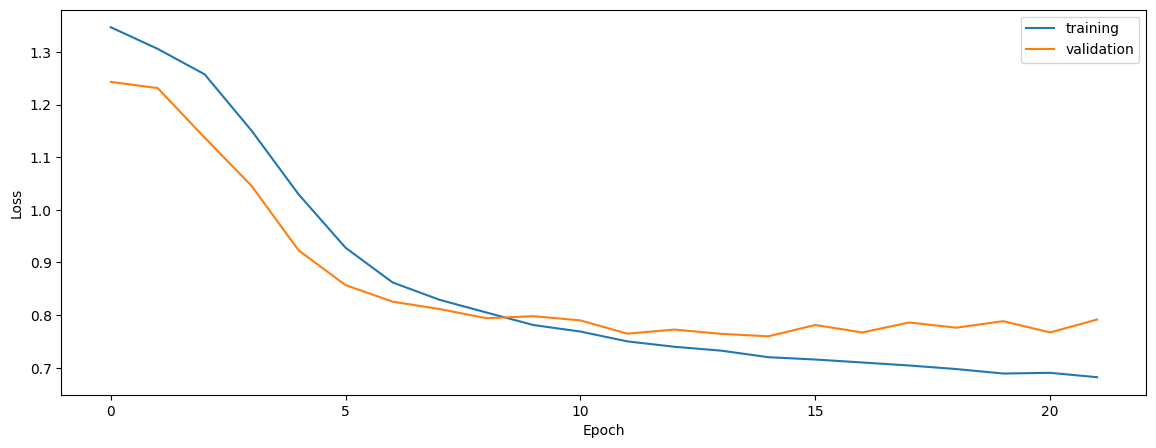

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


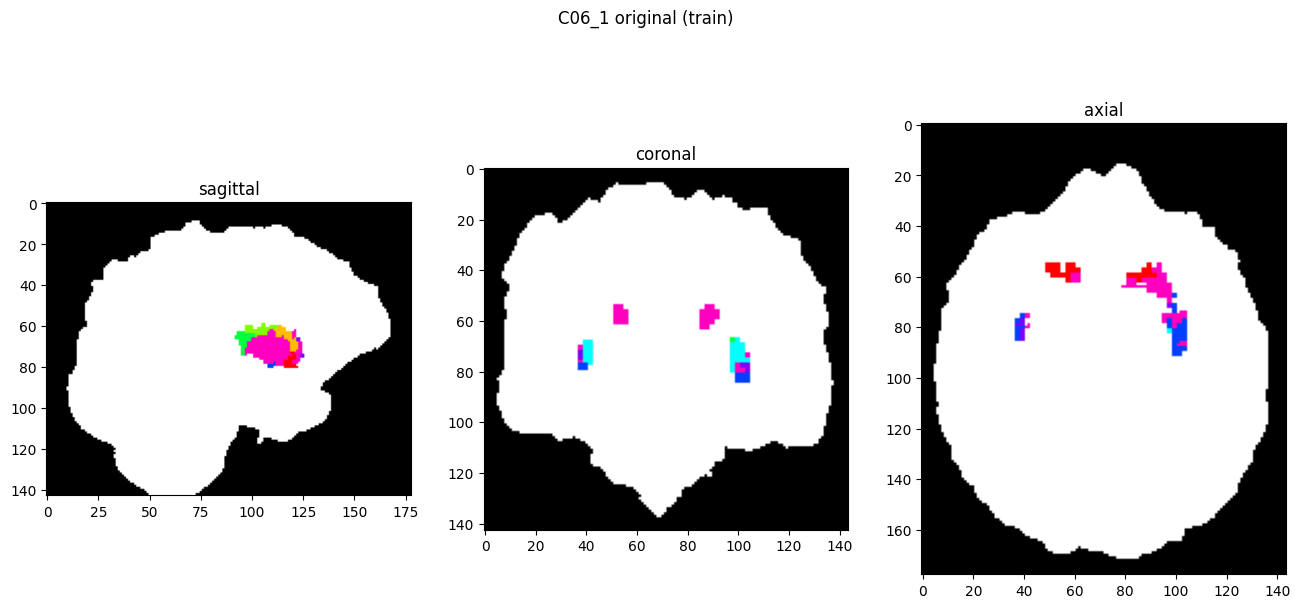

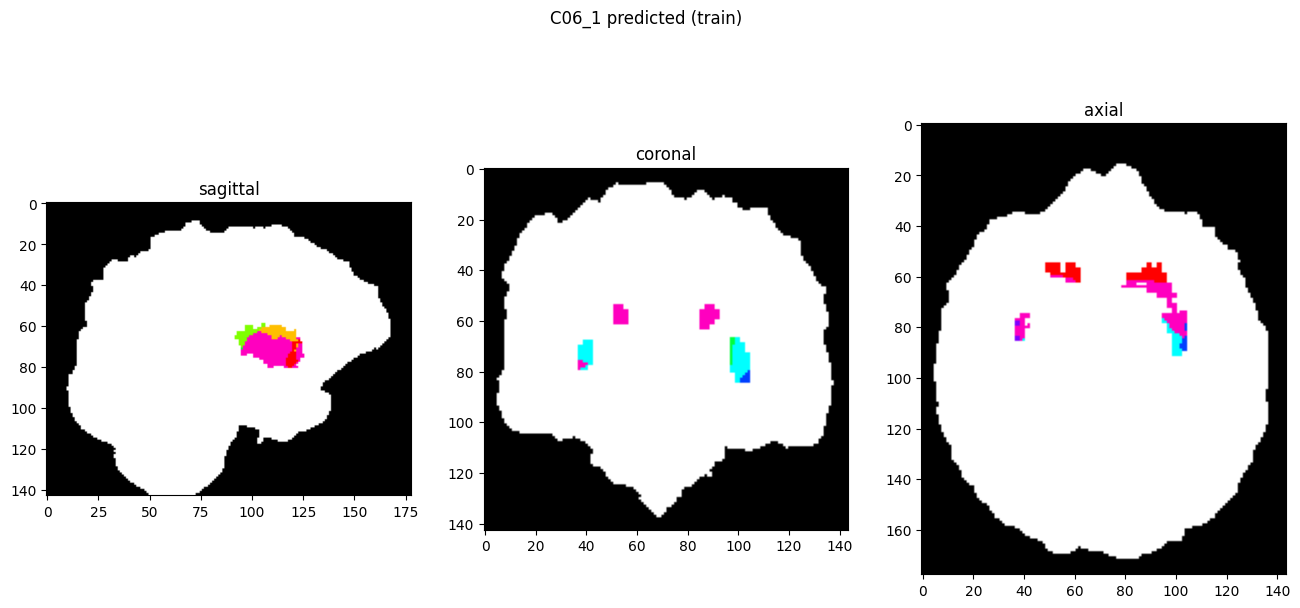

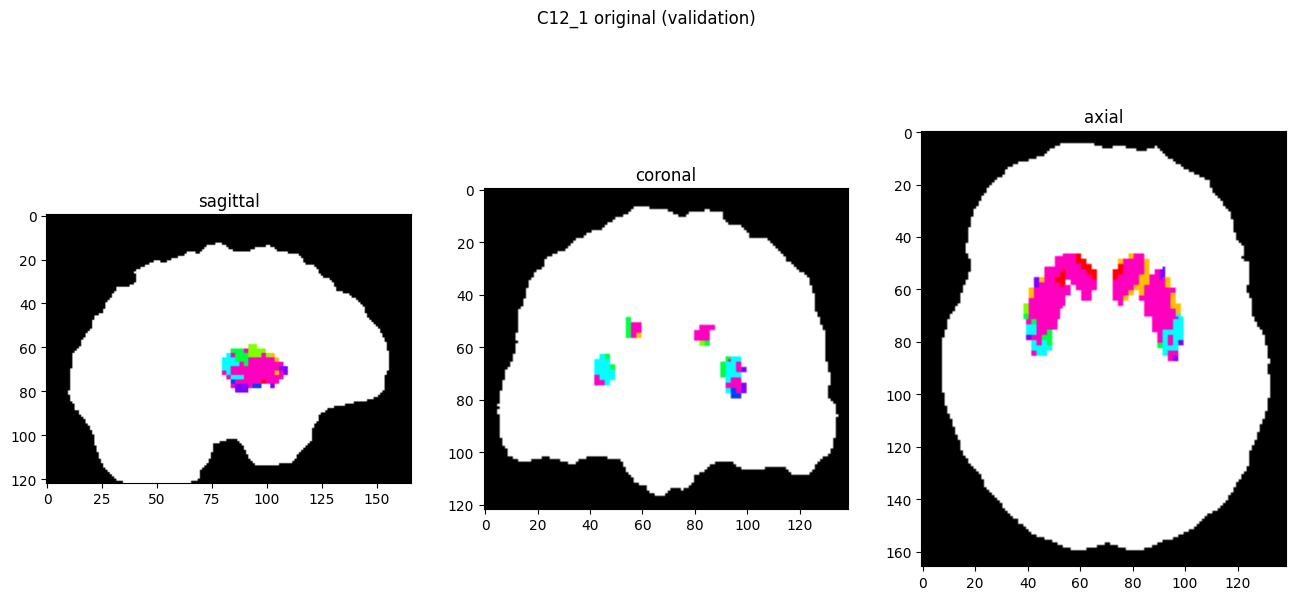

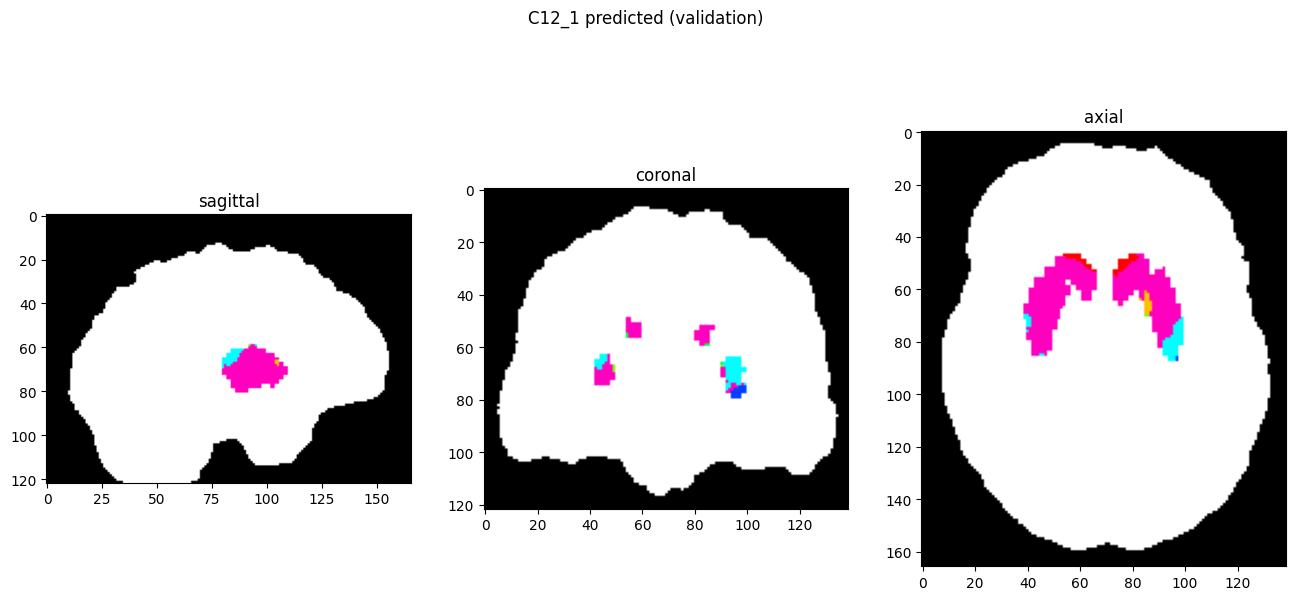

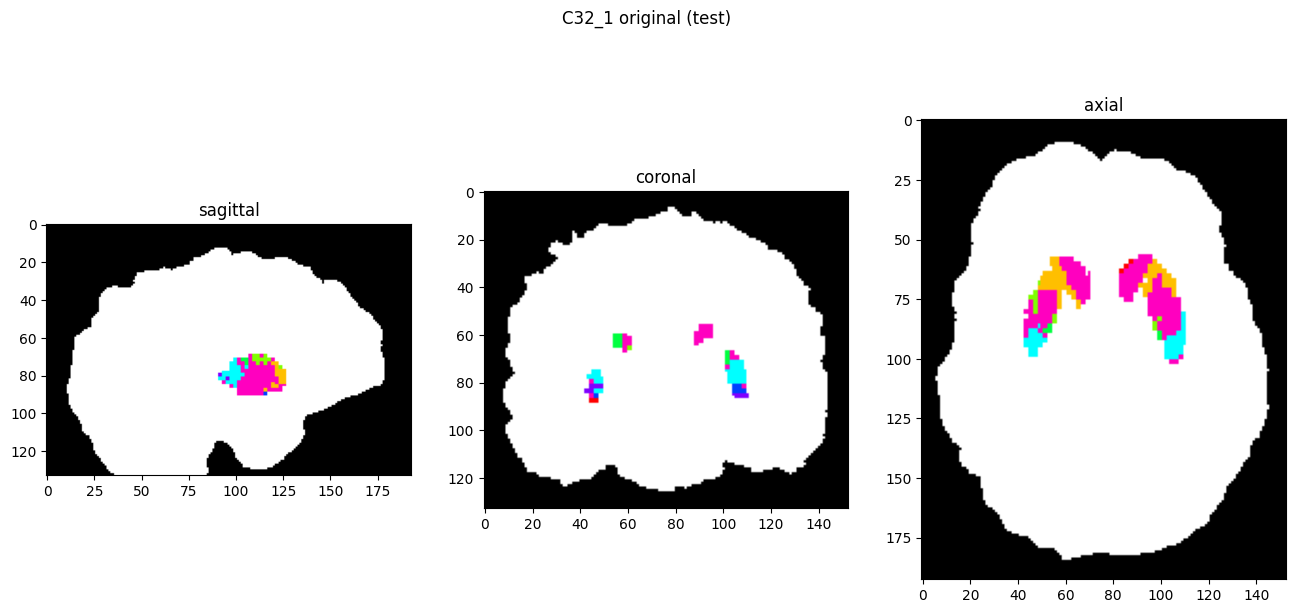

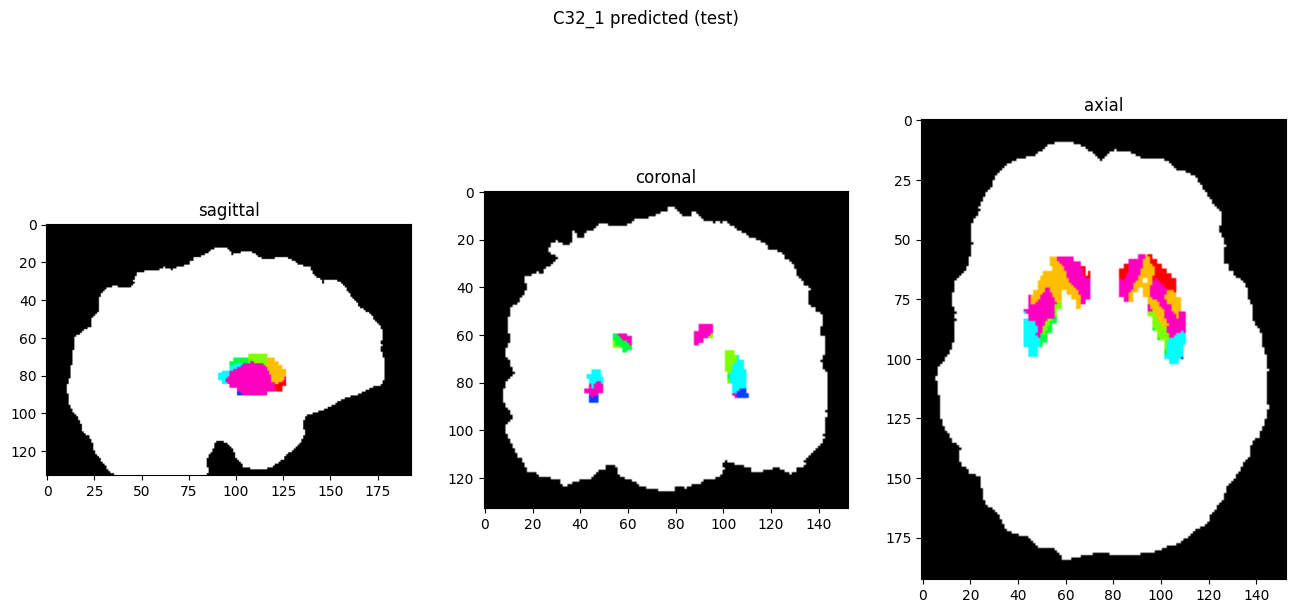

In [10]:
showResults(model, gen, threshold=0)